### Загрузка данных

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c aimasters-ml3-contest01-road-signs

 88% 122M/139M [00:05<00:00, 19.7MB/s]
100% 139M/139M [00:06<00:00, 24.1MB/s]


In [ ]:
! unzip aimasters-ml3-contest01-road-signs.zip

In [1]:
import os
from tqdm import tqdm
import cv2

In [2]:
filenames = []
labels = []

with open("train.csv", "rt") as fp:
    fp.readline()
    for line in fp:
        fn, label = line.strip().split(',')
        filenames.append('train/'+fn)
        labels.append(int(label))

### Сборка датасетов

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T

In [ ]:
class SignsDataset(Dataset):

    def __init__(self, filenames, labels, split, transforms, augmentations = None):
        self.filenames = filenames
        self.labels = labels
        self.split = split  # определяем, какая выборка подаётся
        self.transforms = transforms
        self.augmentations = augmentations

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, i):
        image = cv2.imread(self.filenames[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.
        
        if self.augmentations is not None:
            image = self.augmentations(image=image)['image']
        image_tensor = self.transforms(image)  # превращаем в тензор и делаем трансформации картинок
        
        
        label = self.labels[i]
        
        return image_tensor, label

    @staticmethod
    def collate_fn(items):
        images_batch = torch.zeros(len(items), 3, 48, 48)
        labels_batch = torch.zeros(len(items))
        for i, item in enumerate(items):
            images_batch[i] = item[0]
            labels_batch[i] = item[1]
        return images_batch.float(), labels_batch.long()

In [ ]:
transforms_simple = T.Compose([
    T.ToTensor() 
])

In [ ]:
dataset = SignsDataset(filenames, labels, "train", transforms_simple)

In [ ]:
means = []
stds = []
for i in tqdm(range(len(dataset))):
    means.append(torch.mean(dataset[i][0], dim =[1,2]).numpy())
    stds.append(torch.std(dataset[i][0], dim =[1,2]).numpy())
means = torch.tensor(means)
stds = torch.tensor(stds)

100%|██████████| 25432/25432 [00:13<00:00, 1852.36it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  


In [ ]:
channel_means = torch.mean(means, dim = 0).float()
channel_stds = torch.mean(stds, dim = 0).float()

In [ ]:
transforms = T.Compose([
    T.ToTensor(),
    T.Normalize(channel_means, channel_stds) 
])

In [ ]:
filenames_train, filenames_val, labels_train,  labels_val = train_test_split(filenames, labels, train_size=0.9, stratify=labels)

In [ ]:
dataset_train = SignsDataset(filenames_train, labels_train, "train", transforms)

In [ ]:
def tensor_to_image(tensor):    
    tensor_denormed = tensor * channel_stds.reshape(3,1,1) + channel_means.reshape(3,1,1)  # 3, 48, 48
    image = tensor_denormed.permute(1,2,0).numpy()
    return image

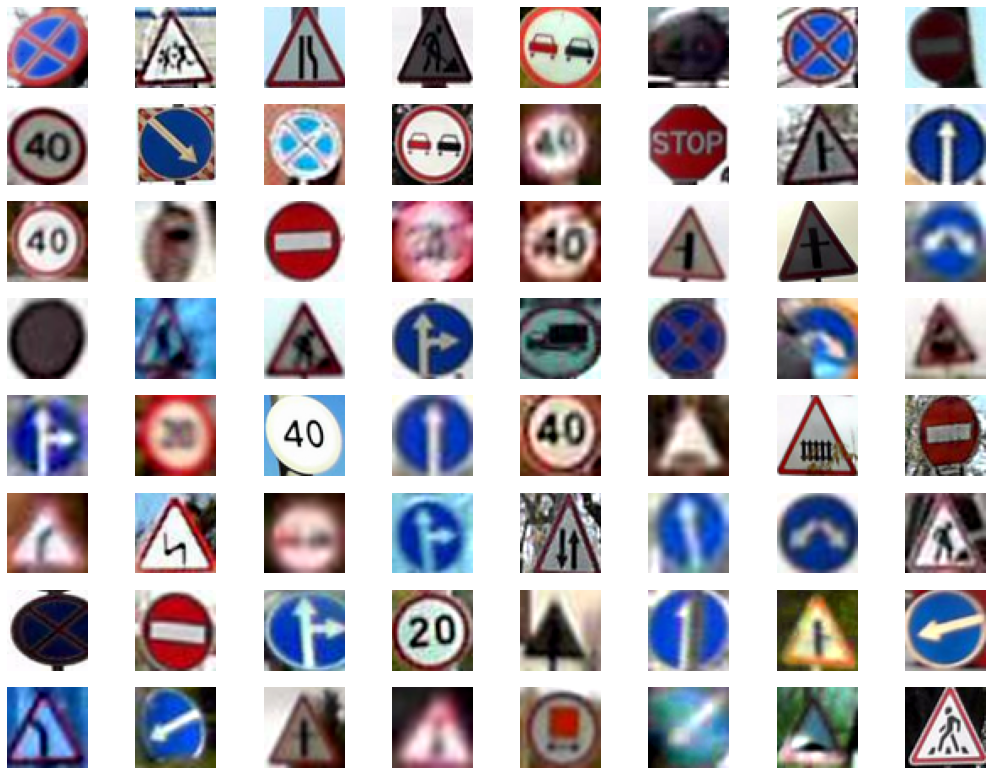

In [ ]:
indexes_to_show = np.random.choice(len(dataset_train), size=64, replace=False)

plt.figure(figsize=(18, 14))
for i, index in enumerate(indexes_to_show):
    tensor, label = dataset_train[index]
    image = tensor_to_image(tensor)
    plt.subplot(8, 8, i + 1)
    plt.imshow(image)
    plt.axis(False)
plt.show()

In [ ]:
a, b = np.unique(dataset_train.labels, return_counts = True)

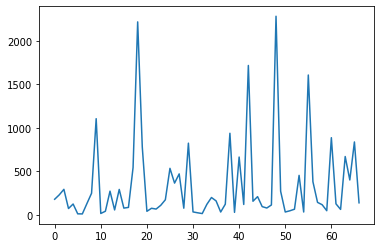

In [ ]:
plt.plot(a,b)

In [ ]:
dataset_val = SignsDataset(filenames_val, labels_val, "val", transforms)

### Построение модели

#### Baseline

In [ ]:
class CNNBlock(nn.Module):

    def __init__(self, in_channels, out_channels, pool=True):
        super(CNNBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = (3,3), padding = (1,1), bias = False)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = (3,3), padding = (1,1), bias = False)
        
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d((2,2)) if pool else nn.Identity()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        return x

Соберем из этих блоков сеть:

In [ ]:
cnn_baseline = nn.Sequential(
    CNNBlock(3, 32),
    CNNBlock(32, 64),
    CNNBlock(64, 128),
    CNNBlock(128, 256),
    CNNBlock(256, 512),

    nn.AdaptiveAvgPool2d((1, 1)), # чтобы не считать размерность тензора, прменяем пулинг, который сам их вычисляет
  
    nn.Flatten(),
    nn.Linear(512, 67) # так как всего 67 видов знаков
)

In [ ]:
x = torch.randn(4, 3, 48, 48)
y = cnn_baseline(x)
y.shape

torch.Size([4, 67])

##### Обучение

In [ ]:
num_epochs = 16
batch_size = 128
lr = 3e-4

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


In [ ]:
dataloader_train = DataLoader(dataset_train, 
                              collate_fn=SignsDataset.collate_fn, 
                              batch_size=batch_size, shuffle=True, drop_last=True, 
                              num_workers=4, pin_memory=True)

dataloader_val = DataLoader(dataset_val, 
                            collate_fn=SignsDataset.collate_fn, 
                            batch_size=batch_size, shuffle=False, drop_last=False, 
                            num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_baseline.parameters(), lr = lr)

In [ ]:
def run_epoch(stage, model, dataloader, loss_fn, optimizer, epoch, device):
    
    # v NOTE THIS v
    if stage == "train":
        model.train()
        torch.set_grad_enabled(True)
    else:
        torch.set_grad_enabled(False)
        model.eval()
    # ^ NOTE THIS ^

    model = model.to(device)
    
    losses = []
    for batch in tqdm(dataloader, total=len(dataloader), desc=f"epoch: {str(epoch).zfill(3)} | {stage:5}"):
        xs, ys_true = batch
                
        ys_pred = model(xs.to(device))
        loss = loss_fn(ys_pred, ys_true.to(device))

        if stage == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
                
        losses.append(loss.detach().cpu().item())

    return np.mean(losses)

Будем контролировать значение целевой метрики (сегодня это `val_loss`), и сохранять чекпоинт модели в случае, если он лучший.

In [ ]:
def save_checkpoint(model, filename):

    with open(filename, "wb") as fp:
        torch.save(model.state_dict(), fp)

def load_checkpoint(model, filename):

    with open(filename, "rb") as fp:
        state_dict = torch.load(fp, map_location="cpu")
    
    model.load_state_dict(state_dict)

In [ ]:
def run_experiment(model, dataloader_train, dataloader_val, loss_fn, optimizer, num_epochs, device, output_dir):
    
    train_losses = []
    val_losses = []

    best_val_loss = np.inf
    best_val_loss_epoch = -1
    best_val_loss_fn = None

    os.makedirs(output_dir, exist_ok=True)

    for epoch in range(num_epochs):
        train_loss = run_epoch("train", model, dataloader_train, loss_fn, optimizer, epoch, device)
        train_losses.append(train_loss)

        val_loss = run_epoch("val", model, dataloader_val, loss_fn, optimizer, epoch, device)
        val_losses.append(val_loss)

        print(f"epoch: {str(epoch).zfill(3)} | train_loss: {train_loss:5.3f}, val_loss: {val_loss:5.3f} (best: {best_val_loss:5.3f})")

        if val_loss < best_val_loss:

            best_val_loss = val_loss
            best_val_loss_epoch = epoch

            output_fn = os.path.join(output_dir, f"epoch={str(epoch).zfill(2)}_valloss={best_val_loss:.3f}.pth.tar")
            save_checkpoint(model, output_fn)
            print(f"New checkpoint saved to {output_fn}")

            best_val_loss_fn = output_fn

        print()

    print (f"Best val_loss = {best_val_loss:.3f} reached at epoch {best_val_loss_epoch}")
    load_checkpoint(model, best_val_loss_fn)

    return train_losses, val_losses, best_val_loss, model

Запустим:

In [ ]:
train_losses_baseline, val_losses_baseline, best_val_loss_baseline, cnn_baseline = run_experiment(
    cnn_baseline, dataloader_train, dataloader_val, loss_fn, optimizer, num_epochs, device, "checkpoints_baseline"
)

Смотрим результаты:

In [ ]:
def plot_losses(train_losses, val_losses, title):
    plt.figure(figsize=(12, 5))
    plt.title(title)
    plt.plot(train_losses, label="train")
    plt.plot(val_losses, label="val")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.grid(True)
    plt.legend()
    plt.show()

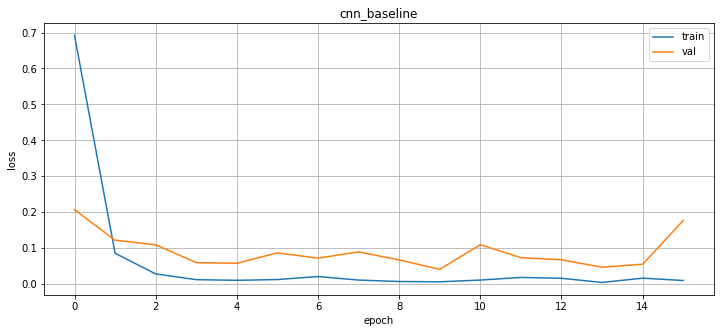

In [ ]:
plot_losses(train_losses_baseline, val_losses_baseline, title="cnn_baseline")

Считаем метрики:

In [ ]:
def collect_predictions(model, dataloader, device):
    model.eval()
    model = model.to(device)
    torch.set_grad_enabled(False)

    labels_all = []
    probs_all = []
    preds_all = []
    for batch in tqdm(dataloader, total=len(dataloader)):
        images, labels = batch

        logits = model(images.to(device)).cpu()
        probs = logits.softmax(dim=1)
        max_prob, max_prob_index = torch.max(probs, dim=1)

        labels_all.extend(labels.numpy().tolist())
        probs_all.extend(max_prob.numpy().tolist())
        preds_all.extend(max_prob_index.numpy().tolist())
    
    return labels_all, probs_all, preds_all

In [ ]:
train_labels, train_probs, train_preds = collect_predictions(cnn_baseline, dataloader_train, device)

accuracy_train = accuracy_score(train_labels, train_preds)
accuracy_train

  0%|          | 0/178 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 178/178 [00:10<00:00, 17.44it/s]


0.9998683286516854

In [ ]:
train_labels[:5], train_preds[:5], train_probs[:5]

([25, 63, 38, 42, 53],
 [25, 63, 38, 42, 53],
 [0.9999803304672241,
  0.9994322657585144,
  0.9999852180480957,
  0.9998553991317749,
  0.999997615814209])

In [ ]:
val_labels, val_probs, val_preds = collect_predictions(cnn_baseline, dataloader_val, device)

accuracy_val = accuracy_score(val_labels, val_preds)
accuracy_val

  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 20/20 [00:01<00:00, 16.20it/s]


0.9886006289308176

##### Формирование результатов на тестовой выборке

In [ ]:
filenames_test = []
labels_test = []

with open("sampleSubmission.csv", "rt") as fp:
    fp.readline()
    for line in fp:
        fn, label = line.strip().split(',')
        filenames_test.append('test/'+fn)
        labels_test.append(int(label))

In [ ]:
dataset_test = SignsDataset(filenames_test, labels_test, "eval", transforms)

In [ ]:
dataloader_test = DataLoader(dataset_test, 
                            collate_fn=SignsDataset.collate_fn, 
                            batch_size=batch_size, shuffle=False, drop_last=False, 
                            num_workers=4, pin_memory=True)

In [ ]:
test_labels, test_probs, test_preds = collect_predictions(cnn_baseline, dataloader_test, device)

100%|██████████| 59/59 [00:02<00:00, 20.97it/s]


In [ ]:
results = pd.read_csv("sampleSubmission.csv", index_col = "filename")

In [ ]:
results.class_number = test_preds

In [ ]:
results.to_csv("sampleSubmission_1.csv")

#### Добавим аугментацию

In [ ]:
import albumentations as A

In [ ]:
aug = A.Compose([
    A.ShiftScaleRotate(),
    A.AdvancedBlur(),
    A.OpticalDistortion(),
    A.RandomBrightnessContrast(),
])

In [ ]:
dataset_aug = SignsDataset(filenames, labels, "train", transforms_simple, aug)

means = []
stds = []
for i in tqdm(range(len(dataset_aug))):
    means.append(torch.mean(dataset_aug[i][0], dim =[1,2]).numpy())
    stds.append(torch.std(dataset_aug[i][0], dim =[1,2]).numpy())
means = torch.tensor(means)
stds = torch.tensor(stds)

channel_means = torch.mean(means, dim = 0).float()
channel_stds = torch.mean(stds, dim = 0).float()

100%|██████████| 25432/25432 [01:30<00:00, 281.58it/s]


In [ ]:
dataset_aug_train = SignsDataset(filenames_train, labels_train, "train", transforms, aug)

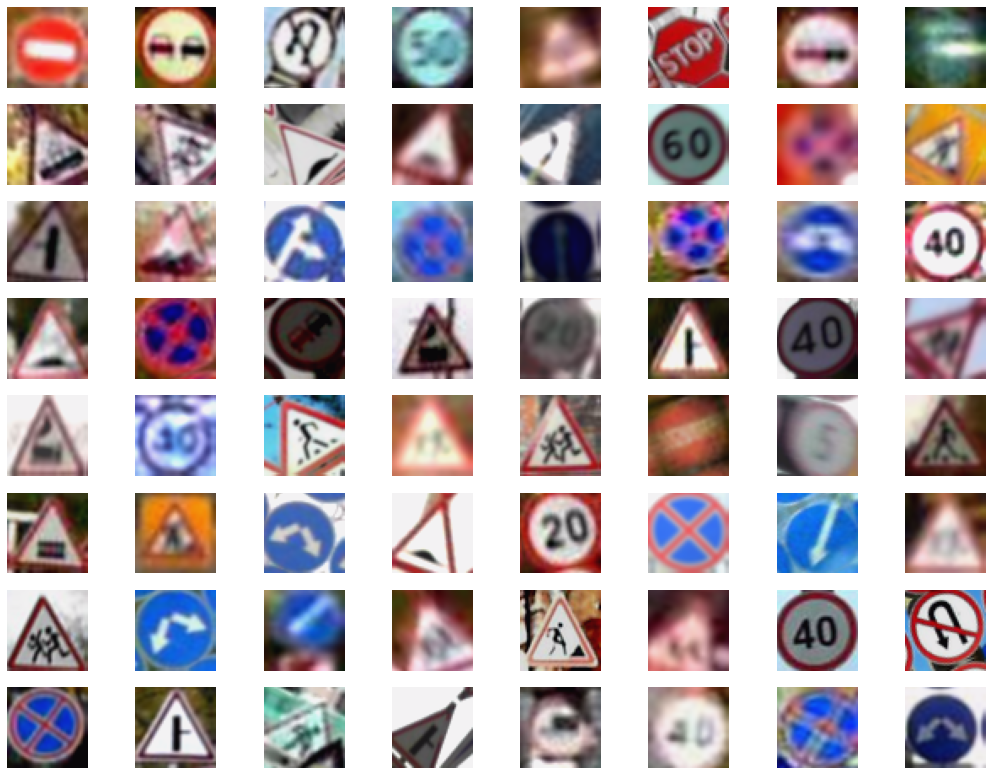

In [ ]:
indexes_to_show = np.random.choice(len(dataset_aug_train), size=64, replace=False)

plt.figure(figsize=(18, 14))
for i, index in enumerate(indexes_to_show):
    tensor, label = dataset_aug_train[index]
    image = tensor_to_image(tensor)
    plt.subplot(8, 8, i + 1)
    plt.imshow(image)
    plt.axis(False)
plt.show()

Валидационный датасет не меняем

In [ ]:
dataset_val = SignsDataset(filenames_val, labels_val, "val", transforms)

In [ ]:
cnn_aug = nn.Sequential(
    CNNBlock(3, 32),
    CNNBlock(32, 64),
    CNNBlock(64, 128),
    CNNBlock(128, 256),
    CNNBlock(256, 512),

    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(512, 67)
)

Увеличим число эпох (забегая вперед - переобучение мы немного снизим, поэтому имеет смысл добавить итераций).

In [ ]:
num_epochs = 32
batch_size = 128
lr = 3e-4

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


In [ ]:
dataloader_aug_train = DataLoader(dataset_aug_train, 
                                  collate_fn=SignsDataset.collate_fn, 
                                  batch_size=batch_size, shuffle=True, drop_last=True, 
                                  num_workers=4, pin_memory=True)

dataloader_val = DataLoader(dataset_val, 
                            collate_fn=SignsDataset.collate_fn, 
                            batch_size=batch_size, shuffle=False, drop_last=False, 
                            num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(cnn_aug.parameters(), lr=lr)

In [ ]:
train_losses_aug, val_losses_aug, best_val_loss_aug, cnn_aug = run_experiment(
    cnn_aug, dataloader_aug_train, dataloader_val, loss_fn, optimizer, num_epochs, device, "checkpoints_aug"
)

In [ ]:
plot_losses(train_losses_aug, val_losses_aug, title="cnn_aug")

In [ ]:
train_labels, train_probs, train_preds = collect_predictions(cnn_aug, dataloader_aug_train, device)

accuracy_train = accuracy_score(train_labels, train_preds)
accuracy_train

100%|██████████| 178/178 [00:32<00:00,  5.46it/s]


0.9921875

In [ ]:
val_labels, val_probs, val_preds = collect_predictions(cnn_aug, dataloader_val, device)

accuracy_val = accuracy_score(val_labels, val_preds)
accuracy_val

  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 20/20 [00:01<00:00, 16.07it/s]


0.9929245283018868

##### Формирование результатов на тестовой выборке

In [ ]:
dataset_test = SignsDataset(filenames_test, labels_test, "eval", transforms)

In [ ]:
dataloader_test = DataLoader(dataset_test, 
                            collate_fn=SignsDataset.collate_fn, 
                            batch_size=batch_size, shuffle=False, drop_last=False, 
                            num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
test_labels, test_probs, test_preds = collect_predictions(cnn_aug, dataloader_test, device)

100%|██████████| 59/59 [00:02<00:00, 21.00it/s]


In [ ]:
results = pd.read_csv("sampleSubmission.csv", index_col = "filename")

In [ ]:
results.class_number = test_preds

In [ ]:
results.to_csv("sampleSubmission_2.csv")

Добавим ещё аугментаций

In [ ]:
aug = A.Compose([
    A.ShiftScaleRotate(),
    A.AdvancedBlur(),
    A.OpticalDistortion(),
    A.RandomBrightnessContrast(),
    A.RandomGamma(),
    A.Sharpen(),
    A.MotionBlur()
])

In [ ]:
dataset_aug = SignsDataset(filenames, labels, "train", transforms_simple, aug)

means = []
stds = []
for i in tqdm(range(len(dataset_aug))):
    means.append(torch.mean(dataset_aug[i][0], dim =[1,2]).numpy())
    stds.append(torch.std(dataset_aug[i][0], dim =[1,2]).numpy())
means = torch.tensor(means)
stds = torch.tensor(stds)

channel_means = torch.mean(means, dim = 0).float()
channel_stds = torch.mean(stds, dim = 0).float()

100%|██████████| 25432/25432 [01:42<00:00, 249.23it/s]


In [ ]:
dataset_aug_train = SignsDataset(filenames_train, labels_train, "train", transforms, aug)

In [ ]:
indexes_to_show = np.random.choice(len(dataset_aug_train), size=64, replace=False)

plt.figure(figsize=(18, 14))
for i, index in enumerate(indexes_to_show):
    tensor, label = dataset_aug_train[index]
    image = tensor_to_image(tensor)
    plt.subplot(8, 8, i + 1)
    plt.imshow(image)
    plt.axis(False)
plt.show()

In [ ]:
dataset_val = SignsDataset(filenames_val, labels_val, "val", transforms)

In [ ]:
cnn_aug = nn.Sequential(
    CNNBlock(3, 32),
    CNNBlock(32, 64),
    CNNBlock(64, 128),
    CNNBlock(128, 256),
    CNNBlock(256, 512),

    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(512, 67)
)

In [ ]:
num_epochs = 32
batch_size = 128
lr = 3e-4

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


In [ ]:
dataloader_aug_train = DataLoader(dataset_aug_train, 
                                  collate_fn=SignsDataset.collate_fn, 
                                  batch_size=batch_size, shuffle=True, drop_last=True, 
                                  num_workers=4, pin_memory=True)

dataloader_val = DataLoader(dataset_val, 
                            collate_fn=SignsDataset.collate_fn, 
                            batch_size=batch_size, shuffle=False, drop_last=False, 
                            num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(cnn_aug.parameters(), lr=lr)

In [ ]:
train_losses_aug, val_losses_aug, best_val_loss_aug, cnn_aug = run_experiment(
    cnn_aug, dataloader_aug_train, dataloader_val, loss_fn, optimizer, num_epochs, device, "checkpoints_aug"
)

In [ ]:
plot_losses(train_losses_aug, val_losses_aug, title="cnn_aug")

In [ ]:
train_labels, train_probs, train_preds = collect_predictions(cnn_aug, dataloader_aug_train, device)

accuracy_train = accuracy_score(train_labels, train_preds)
accuracy_train

100%|██████████| 178/178 [00:38<00:00,  4.62it/s]


0.9915730337078652

In [ ]:
val_labels, val_probs, val_preds = collect_predictions(cnn_aug, dataloader_val, device)

accuracy_val = accuracy_score(val_labels, val_preds)
accuracy_val

  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 20/20 [00:01<00:00, 15.87it/s]


0.9937106918238994

##### Формирование результатов на тестовой выборке

In [ ]:
test_labels, test_probs, test_preds = collect_predictions(cnn_aug, dataloader_test, device)

  0%|          | 0/59 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 59/59 [00:03<00:00, 18.39it/s]


In [ ]:
results = pd.read_csv("sampleSubmission.csv", index_col = "filename")

In [ ]:
results.class_number = test_preds

In [ ]:
results.to_csv("sampleSubmission_3.csv")

И ещё больше аугментаций

In [ ]:
aug = A.Compose([
    A.ShiftScaleRotate(),
    A.AdvancedBlur(),
    A.OpticalDistortion(),
    A.RandomBrightnessContrast(),
    A.RandomGamma(),
    A.Sharpen(),
    A.MotionBlur(),
    A.ChannelDropout(),
    A.Emboss(),
    A.Solarize()
])

In [ ]:
dataset_aug = SignsDataset(filenames, labels, "train", transforms_simple, aug)

means = []
stds = []
for i in tqdm(range(len(dataset_aug))):
    means.append(torch.mean(dataset_aug[i][0], dim =[1,2]).numpy())
    stds.append(torch.std(dataset_aug[i][0], dim =[1,2]).numpy())
means = torch.tensor(means)
stds = torch.tensor(stds)

channel_means = torch.mean(means, dim = 0).float()
channel_stds = torch.mean(stds, dim = 0).float()

100%|██████████| 25432/25432 [01:26<00:00, 292.97it/s]


In [ ]:
dataset_aug_train = SignsDataset(filenames_train, labels_train, "train", transforms, aug)

In [ ]:
indexes_to_show = np.random.choice(len(dataset_aug_train), size=64, replace=False)

plt.figure(figsize=(18, 14))
for i, index in enumerate(indexes_to_show):
    tensor, label = dataset_aug_train[index]
    image = tensor_to_image(tensor)
    plt.subplot(8, 8, i + 1)
    plt.imshow(image)
    plt.axis(False)
plt.show()

In [ ]:
dataset_val = SignsDataset(filenames_val, labels_val, "val", transforms)

In [ ]:
cnn_aug = nn.Sequential(
    CNNBlock(3, 32),
    CNNBlock(32, 64),
    CNNBlock(64, 128),
    CNNBlock(128, 256),
    CNNBlock(256, 512),

    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(512, 67)
)

Ещё увеличим число эпох, так как переобучение уменьшили с помощью аугментаций

In [ ]:
num_epochs = 40
batch_size = 128
lr = 3e-4

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


In [ ]:
dataloader_aug_train = DataLoader(dataset_aug_train, 
                                  collate_fn=SignsDataset.collate_fn, 
                                  batch_size=batch_size, shuffle=True, drop_last=True, 
                                  num_workers=4, pin_memory=True)

dataloader_val = DataLoader(dataset_val, 
                            collate_fn=SignsDataset.collate_fn, 
                            batch_size=batch_size, shuffle=False, drop_last=False, 
                            num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(cnn_aug.parameters(), lr=lr)

In [ ]:
train_losses_aug, val_losses_aug, best_val_loss_aug, cnn_aug = run_experiment(
    cnn_aug, dataloader_aug_train, dataloader_val, loss_fn, optimizer, num_epochs, device, "checkpoints_aug"
)

In [ ]:
plot_losses(train_losses_aug, val_losses_aug, title="cnn_aug")

In [ ]:
train_labels, train_probs, train_preds = collect_predictions(cnn_aug, dataloader_aug_train, device)

accuracy_train = accuracy_score(train_labels, train_preds)
accuracy_train

100%|██████████| 178/178 [00:33<00:00,  5.36it/s]


0.9910902387640449

In [ ]:
val_labels, val_probs, val_preds = collect_predictions(cnn_aug, dataloader_val, device)

accuracy_val = accuracy_score(val_labels, val_preds)
accuracy_val

  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 20/20 [00:01<00:00, 18.37it/s]


0.9901729559748428

In [ ]:
test_labels, test_probs, test_preds = collect_predictions(cnn_aug, dataloader_test, device)

100%|██████████| 59/59 [00:02<00:00, 23.06it/s]


In [ ]:
results = pd.read_csv("sampleSubmission.csv", index_col = "filename")

In [ ]:
results.class_number = test_preds

In [ ]:
results.to_csv("sampleSubmission_4.csv")

#### Усложним модель

In [ ]:
cnn_aug = nn.Sequential(
    CNNBlock(3, 64),
    CNNBlock(64, 128),
    CNNBlock(128, 256),
    CNNBlock(256, 512),
    CNNBlock(512, 1024),

    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(1024, 67)
)

In [ ]:
num_epochs = 40
batch_size = 128
lr = 3e-4

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


In [ ]:
dataloader_aug_train = DataLoader(dataset_aug_train, 
                                  collate_fn=SignsDataset.collate_fn, 
                                  batch_size=batch_size, shuffle=True, drop_last=True, 
                                  num_workers=4, pin_memory=True)

dataloader_val = DataLoader(dataset_val, 
                            collate_fn=SignsDataset.collate_fn, 
                            batch_size=batch_size, shuffle=False, drop_last=False, 
                            num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(cnn_aug.parameters(), lr=lr)

In [ ]:
train_losses_aug, val_losses_aug, best_val_loss_aug, cnn_aug = run_experiment(
    cnn_aug, dataloader_aug_train, dataloader_val, loss_fn, optimizer, num_epochs, device, "checkpoints_aug"
)

In [ ]:
filenames_test = []
labels_test = []

with open("sampleSubmission.csv", "rt") as fp:
    fp.readline()
    for line in fp:
        fn, label = line.strip().split(',')
        filenames_test.append('test/'+fn)
        labels_test.append(int(label))

In [ ]:
dataset_test = SignsDataset(filenames_test, labels_test, "eval", transforms)

In [ ]:
dataloader_test = DataLoader(dataset_test, 
                            collate_fn=SignsDataset.collate_fn, 
                            batch_size=batch_size, shuffle=False, drop_last=False, 
                            num_workers=4, pin_memory=True)

In [ ]:
test_labels, test_probs, test_preds = collect_predictions(cnn_aug, dataloader_test, device)

100%|██████████| 59/59 [00:06<00:00,  8.55it/s]


In [ ]:
results = pd.read_csv("sampleSubmission.csv", index_col = "filename")

In [ ]:
results.class_number = test_preds

In [ ]:
results.to_csv("sampleSubmission_5.csv")

### Воспольуемся предобученной моделью

Важнейший прием, которым следует овладеть - это пользоваться готовыми моделями :)

Часто (*да почти всегда*) лучше учиться не со случайных весов. Если у вас в наличии есть модель, уже обученная на хоть сколько-нибудь смежном домене с целевым - надо брать и дообучаться с нее.

Откуда брать модели?
* [`torchvision.models`](https://pytorch.org/vision/0.8/models.html)
* [`pytorch_image_models`](https://github.com/rwightman/pytorch-image-models)
* ...

In [ ]:
from torchvision import models as M

ResNet - база. Возьмем восемнадцатый:

![resnet](https://velog.velcdn.com/images%2Fe_sin528%2Fpost%2Fe272c056-3dfa-4bb6-bfc9-b309d82df932%2FResNet18.png)

In [ ]:
resnet18 = M.resnet18(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
x = torch.randn(1, 3, 224, 224)

y = resnet18(x)
y.size()

torch.Size([1, 1000])

Как использовать готовую модель?
* Заменить выходной слой на слой с нужным числом классов
  * `timm` умеет это прямо при инициализации
* Взять `feature_extractor` модели и навернуть сверху своих слоев
  * `timm` опять же позволяет это легко сделать
  
У нас особенный случай: ResNet18 уменьшает размер входного изображения в 64 раза, а у нас картинки 48х48. Как быть?

Например, можно взять и выдрать слои из модели и поместить в `Sequential`, приправив своими слоями сверху:

In [ ]:
cnn_finetuned = nn.Sequential(
    resnet18.conv1,
    resnet18.bn1,
    resnet18.relu,
    resnet18.maxpool,
    resnet18.layer1,
    resnet18.layer2,

    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(128, 67)
)

In [ ]:
x = torch.randn(1, 3, 48, 48)

In [ ]:
cnn_finetuned(x)

tensor([[ 3.0890e-01,  9.4473e-02, -2.5985e-03,  7.4137e-02,  3.8327e-02,
         -4.9906e-02, -2.0034e-01,  4.1879e-02,  1.3973e-02, -1.8316e-01,
          6.6337e-02, -4.2514e-02, -1.0487e-01,  4.6358e-02, -9.4900e-02,
         -1.9458e-01,  2.7834e-02,  1.1133e-01,  1.0664e-01,  1.9978e-01,
          1.0039e-01, -6.2118e-02,  4.9785e-02, -3.5465e-02, -2.6079e-01,
         -1.2338e-01,  1.1194e-02,  2.9271e-04,  1.3260e-01, -1.7425e-01,
         -5.2606e-02,  5.4180e-02, -1.8343e-01,  1.2649e-02,  2.4575e-02,
         -1.0520e-01, -1.5498e-01,  1.5892e-01, -1.2205e-01, -1.7980e-02,
         -7.4167e-02, -3.1588e-02, -1.3124e-01, -1.9433e-03, -3.1621e-02,
         -3.0204e-01, -1.2295e-01, -1.0149e-01, -1.6216e-01,  1.1959e-01,
          1.2312e-01, -4.6393e-02, -1.1325e-01, -1.1803e-01, -3.8676e-02,
         -1.1183e-01, -1.0263e-01, -1.6998e-01, -1.3382e-01,  4.8556e-02,
          1.1046e-01,  1.4198e-01,  6.3896e-02,  1.1460e-01,  8.0891e-02,
         -3.6874e-04,  3.5888e-02]], g

Теперь про обучение. Поскольку у нас есть частично обученные веса на входе (из ResNet) и полностью необученные на выходе (свои) веса, градиенты через конец сети могут быть очень шумными. Поэтому есть практика обучения только новых голов в течение пары эпох, а затем полное обучение:

In [ ]:
cnn_finetuned[0].weight.requires_grad, cnn_finetuned[-1].weight.requires_grad

(True, True)

Веса слоев можно заморозить ручками:

In [ ]:
for layer in cnn_finetuned:
    layer.requires_grad_(False)

In [ ]:
cnn_finetuned[0].weight.requires_grad, cnn_finetuned[-1].weight.requires_grad

(False, False)

In [ ]:
cnn_finetuned[-1].requires_grad_(True)
cnn_finetuned[-1].weight.requires_grad

True

Теперь к обучению:

In [ ]:
num_epochs = 40
batch_size = 128
lr = 3e-4 #можно уменьшить

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


In [ ]:
loss_fn = nn.CrossEntropyLoss()

Сначала 5 эпох учим только последний слой:

In [ ]:
optimizer = torch.optim.Adam(cnn_finetuned[-1].parameters(), lr=lr)

In [ ]:
train_losses_finetuned, val_losses_finetuned, best_val_loss_finetuned, cnn_finetuned = run_experiment(
    cnn_finetuned, dataloader_aug_train, dataloader_val, loss_fn, optimizer, 5, device, "checkpoints_finetuned"
)

epoch: 000 | train: 100%|██████████| 178/178 [00:41<00:00,  4.31it/s]
epoch: 000 | val  : 100%|██████████| 20/20 [00:01<00:00, 19.95it/s]


epoch: 000 | train_loss: 3.836, val_loss: 3.570 (best:   inf)
New checkpoint saved to checkpoints_finetuned/epoch=00_valloss=3.570.pth.tar



epoch: 001 | train: 100%|██████████| 178/178 [00:38<00:00,  4.65it/s]
epoch: 001 | val  : 100%|██████████| 20/20 [00:01<00:00, 16.08it/s]


epoch: 001 | train_loss: 3.496, val_loss: 3.401 (best: 3.570)
New checkpoint saved to checkpoints_finetuned/epoch=01_valloss=3.401.pth.tar



epoch: 002 | train: 100%|██████████| 178/178 [00:37<00:00,  4.74it/s]
epoch: 002 | val  : 100%|██████████| 20/20 [00:01<00:00, 19.03it/s]


epoch: 002 | train_loss: 3.389, val_loss: 3.306 (best: 3.401)
New checkpoint saved to checkpoints_finetuned/epoch=02_valloss=3.306.pth.tar



epoch: 003 | train: 100%|██████████| 178/178 [00:36<00:00,  4.90it/s]
epoch: 003 | val  : 100%|██████████| 20/20 [00:01<00:00, 19.37it/s]


epoch: 003 | train_loss: 3.315, val_loss: 3.223 (best: 3.306)
New checkpoint saved to checkpoints_finetuned/epoch=03_valloss=3.223.pth.tar



epoch: 004 | train: 100%|██████████| 178/178 [00:35<00:00,  5.01it/s]
epoch: 004 | val  : 100%|██████████| 20/20 [00:01<00:00, 19.05it/s]

epoch: 004 | train_loss: 3.246, val_loss: 3.142 (best: 3.223)
New checkpoint saved to checkpoints_finetuned/epoch=04_valloss=3.142.pth.tar

Best val_loss = 3.142 reached at epoch 4


Теперь размораживаем всю сеть и учим целиком:

In [ ]:
for layer in cnn_finetuned:
    layer.requires_grad_(True)

optimizer = torch.optim.Adam(cnn_finetuned.parameters(), lr=lr)    

In [ ]:
train_losses_finetuned, val_losses_finetuned, best_val_loss_finetuned, cnn_finetuned = run_experiment(
    cnn_finetuned, dataloader_aug_train, dataloader_val, loss_fn, optimizer, num_epochs, device, "checkpoints_finetuned"
)

epoch: 000 | train:   0%|          | 0/178 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
epoch: 000 | train: 100%|██████████| 178/178 [00:36<00:00,  4.87it/s]
epoch: 000 | val  : 100%|██████████| 20/20 [00:01<00:00, 18.45it/s]


epoch: 000 | train_loss: 2.147, val_loss: 1.432 (best:   inf)
New checkpoint saved to checkpoints_finetuned/epoch=00_valloss=1.432.pth.tar



epoch: 001 | train: 100%|██████████| 178/178 [00:37<00:00,  4.76it/s]
epoch: 001 | val  : 100%|██████████| 20/20 [00:01<00:00, 18.50it/s]


epoch: 001 | train_loss: 1.350, val_loss: 0.951 (best: 1.432)
New checkpoint saved to checkpoints_finetuned/epoch=01_valloss=0.951.pth.tar



epoch: 002 | train: 100%|██████████| 178/178 [00:36<00:00,  4.83it/s]
epoch: 002 | val  : 100%|██████████| 20/20 [00:01<00:00, 18.05it/s]


epoch: 002 | train_loss: 0.930, val_loss: 0.617 (best: 0.951)
New checkpoint saved to checkpoints_finetuned/epoch=02_valloss=0.617.pth.tar



epoch: 003 | train: 100%|██████████| 178/178 [00:37<00:00,  4.71it/s]
epoch: 003 | val  : 100%|██████████| 20/20 [00:01<00:00, 18.54it/s]


epoch: 003 | train_loss: 0.650, val_loss: 0.423 (best: 0.617)
New checkpoint saved to checkpoints_finetuned/epoch=03_valloss=0.423.pth.tar



epoch: 004 | train: 100%|██████████| 178/178 [00:37<00:00,  4.81it/s]
epoch: 004 | val  : 100%|██████████| 20/20 [00:01<00:00, 18.74it/s]


epoch: 004 | train_loss: 0.473, val_loss: 0.291 (best: 0.423)
New checkpoint saved to checkpoints_finetuned/epoch=04_valloss=0.291.pth.tar



epoch: 005 | train: 100%|██████████| 178/178 [00:36<00:00,  4.85it/s]
epoch: 005 | val  : 100%|██████████| 20/20 [00:01<00:00, 18.67it/s]


epoch: 005 | train_loss: 0.360, val_loss: 0.216 (best: 0.291)
New checkpoint saved to checkpoints_finetuned/epoch=05_valloss=0.216.pth.tar



epoch: 006 | train: 100%|██████████| 178/178 [00:36<00:00,  4.84it/s]
epoch: 006 | val  : 100%|██████████| 20/20 [00:01<00:00, 18.50it/s]


epoch: 006 | train_loss: 0.283, val_loss: 0.167 (best: 0.216)
New checkpoint saved to checkpoints_finetuned/epoch=06_valloss=0.167.pth.tar



epoch: 007 | train: 100%|██████████| 178/178 [00:37<00:00,  4.73it/s]
epoch: 007 | val  : 100%|██████████| 20/20 [00:01<00:00, 18.85it/s]


epoch: 007 | train_loss: 0.233, val_loss: 0.130 (best: 0.167)
New checkpoint saved to checkpoints_finetuned/epoch=07_valloss=0.130.pth.tar



epoch: 008 | train: 100%|██████████| 178/178 [00:36<00:00,  4.91it/s]
epoch: 008 | val  : 100%|██████████| 20/20 [00:01<00:00, 18.40it/s]


epoch: 008 | train_loss: 0.193, val_loss: 0.167 (best: 0.130)



epoch: 009 | train: 100%|██████████| 178/178 [00:36<00:00,  4.86it/s]
epoch: 009 | val  : 100%|██████████| 20/20 [00:01<00:00, 18.66it/s]


epoch: 009 | train_loss: 0.173, val_loss: 0.092 (best: 0.130)
New checkpoint saved to checkpoints_finetuned/epoch=09_valloss=0.092.pth.tar



epoch: 010 | train: 100%|██████████| 178/178 [00:36<00:00,  4.92it/s]
epoch: 010 | val  : 100%|██████████| 20/20 [00:01<00:00, 18.36it/s]


epoch: 010 | train_loss: 0.154, val_loss: 0.097 (best: 0.092)



epoch: 011 | train: 100%|██████████| 178/178 [00:37<00:00,  4.73it/s]
epoch: 011 | val  : 100%|██████████| 20/20 [00:01<00:00, 18.47it/s]


epoch: 011 | train_loss: 0.139, val_loss: 0.082 (best: 0.092)
New checkpoint saved to checkpoints_finetuned/epoch=11_valloss=0.082.pth.tar



epoch: 012 | train: 100%|██████████| 178/178 [00:36<00:00,  4.86it/s]
epoch: 012 | val  : 100%|██████████| 20/20 [00:01<00:00, 18.56it/s]


epoch: 012 | train_loss: 0.128, val_loss: 0.067 (best: 0.082)
New checkpoint saved to checkpoints_finetuned/epoch=12_valloss=0.067.pth.tar



epoch: 013 | train: 100%|██████████| 178/178 [00:36<00:00,  4.90it/s]
epoch: 013 | val  : 100%|██████████| 20/20 [00:01<00:00, 18.76it/s]


epoch: 013 | train_loss: 0.114, val_loss: 0.061 (best: 0.067)
New checkpoint saved to checkpoints_finetuned/epoch=13_valloss=0.061.pth.tar



epoch: 014 | train: 100%|██████████| 178/178 [00:36<00:00,  4.89it/s]
epoch: 014 | val  : 100%|██████████| 20/20 [00:01<00:00, 18.51it/s]


epoch: 014 | train_loss: 0.106, val_loss: 0.075 (best: 0.061)



epoch: 015 | train: 100%|██████████| 178/178 [00:37<00:00,  4.69it/s]
epoch: 015 | val  : 100%|██████████| 20/20 [00:01<00:00, 18.49it/s]


epoch: 015 | train_loss: 0.098, val_loss: 0.058 (best: 0.061)
New checkpoint saved to checkpoints_finetuned/epoch=15_valloss=0.058.pth.tar



epoch: 016 | train: 100%|██████████| 178/178 [00:36<00:00,  4.88it/s]
epoch: 016 | val  : 100%|██████████| 20/20 [00:01<00:00, 18.80it/s]


epoch: 016 | train_loss: 0.097, val_loss: 0.059 (best: 0.058)



epoch: 017 | train: 100%|██████████| 178/178 [00:36<00:00,  4.92it/s]
epoch: 017 | val  : 100%|██████████| 20/20 [00:01<00:00, 18.47it/s]


epoch: 017 | train_loss: 0.090, val_loss: 0.070 (best: 0.058)



epoch: 018 | train: 100%|██████████| 178/178 [00:36<00:00,  4.87it/s]
epoch: 018 | val  : 100%|██████████| 20/20 [00:01<00:00, 18.73it/s]


epoch: 018 | train_loss: 0.087, val_loss: 0.058 (best: 0.058)
New checkpoint saved to checkpoints_finetuned/epoch=18_valloss=0.058.pth.tar



epoch: 019 | train: 100%|██████████| 178/178 [00:37<00:00,  4.74it/s]
epoch: 019 | val  : 100%|██████████| 20/20 [00:01<00:00, 18.27it/s]


epoch: 019 | train_loss: 0.082, val_loss: 0.056 (best: 0.058)
New checkpoint saved to checkpoints_finetuned/epoch=19_valloss=0.056.pth.tar



epoch: 020 | train: 100%|██████████| 178/178 [00:36<00:00,  4.92it/s]
epoch: 020 | val  : 100%|██████████| 20/20 [00:01<00:00, 18.72it/s]


epoch: 020 | train_loss: 0.076, val_loss: 0.043 (best: 0.056)
New checkpoint saved to checkpoints_finetuned/epoch=20_valloss=0.043.pth.tar



epoch: 021 | train: 100%|██████████| 178/178 [00:36<00:00,  4.91it/s]
epoch: 021 | val  : 100%|██████████| 20/20 [00:01<00:00, 18.57it/s]


epoch: 021 | train_loss: 0.075, val_loss: 0.043 (best: 0.043)
New checkpoint saved to checkpoints_finetuned/epoch=21_valloss=0.043.pth.tar



epoch: 022 | train: 100%|██████████| 178/178 [00:36<00:00,  4.85it/s]
epoch: 022 | val  : 100%|██████████| 20/20 [00:01<00:00, 19.08it/s]


epoch: 022 | train_loss: 0.074, val_loss: 0.049 (best: 0.043)



epoch: 023 | train: 100%|██████████| 178/178 [00:37<00:00,  4.76it/s]
epoch: 023 | val  : 100%|██████████| 20/20 [00:01<00:00, 18.51it/s]


epoch: 023 | train_loss: 0.071, val_loss: 0.040 (best: 0.043)
New checkpoint saved to checkpoints_finetuned/epoch=23_valloss=0.040.pth.tar



epoch: 024 | train: 100%|██████████| 178/178 [00:35<00:00,  4.96it/s]
epoch: 024 | val  : 100%|██████████| 20/20 [00:01<00:00, 18.32it/s]


epoch: 024 | train_loss: 0.063, val_loss: 0.045 (best: 0.040)



epoch: 025 | train: 100%|██████████| 178/178 [00:36<00:00,  4.88it/s]
epoch: 025 | val  : 100%|██████████| 20/20 [00:01<00:00, 18.10it/s]


epoch: 025 | train_loss: 0.062, val_loss: 0.056 (best: 0.040)



epoch: 026 | train: 100%|██████████| 178/178 [00:36<00:00,  4.90it/s]
epoch: 026 | val  : 100%|██████████| 20/20 [00:01<00:00, 17.95it/s]


epoch: 026 | train_loss: 0.057, val_loss: 0.040 (best: 0.040)
New checkpoint saved to checkpoints_finetuned/epoch=26_valloss=0.040.pth.tar



epoch: 027 | train: 100%|██████████| 178/178 [00:37<00:00,  4.77it/s]
epoch: 027 | val  : 100%|██████████| 20/20 [00:01<00:00, 17.65it/s]


epoch: 027 | train_loss: 0.061, val_loss: 0.043 (best: 0.040)



epoch: 028 | train: 100%|██████████| 178/178 [00:36<00:00,  4.90it/s]
epoch: 028 | val  : 100%|██████████| 20/20 [00:01<00:00, 18.49it/s]


epoch: 028 | train_loss: 0.057, val_loss: 0.046 (best: 0.040)



epoch: 029 | train: 100%|██████████| 178/178 [00:36<00:00,  4.82it/s]
epoch: 029 | val  : 100%|██████████| 20/20 [00:01<00:00, 18.16it/s]


epoch: 029 | train_loss: 0.055, val_loss: 0.039 (best: 0.040)
New checkpoint saved to checkpoints_finetuned/epoch=29_valloss=0.039.pth.tar



epoch: 030 | train: 100%|██████████| 178/178 [00:36<00:00,  4.88it/s]
epoch: 030 | val  : 100%|██████████| 20/20 [00:01<00:00, 18.74it/s]


epoch: 030 | train_loss: 0.053, val_loss: 0.035 (best: 0.039)
New checkpoint saved to checkpoints_finetuned/epoch=30_valloss=0.035.pth.tar



epoch: 031 | train: 100%|██████████| 178/178 [00:38<00:00,  4.66it/s]
epoch: 031 | val  : 100%|██████████| 20/20 [00:01<00:00, 17.89it/s]


epoch: 031 | train_loss: 0.053, val_loss: 0.040 (best: 0.035)



epoch: 032 | train: 100%|██████████| 178/178 [00:36<00:00,  4.83it/s]
epoch: 032 | val  : 100%|██████████| 20/20 [00:01<00:00, 18.58it/s]


epoch: 032 | train_loss: 0.056, val_loss: 0.035 (best: 0.035)



epoch: 033 | train: 100%|██████████| 178/178 [00:36<00:00,  4.90it/s]
epoch: 033 | val  : 100%|██████████| 20/20 [00:01<00:00, 18.70it/s]


epoch: 033 | train_loss: 0.056, val_loss: 0.032 (best: 0.035)
New checkpoint saved to checkpoints_finetuned/epoch=33_valloss=0.032.pth.tar



epoch: 034 | train: 100%|██████████| 178/178 [00:36<00:00,  4.89it/s]
epoch: 034 | val  : 100%|██████████| 20/20 [00:01<00:00, 18.39it/s]


epoch: 034 | train_loss: 0.050, val_loss: 0.034 (best: 0.032)



epoch: 035 | train: 100%|██████████| 178/178 [00:37<00:00,  4.76it/s]
epoch: 035 | val  : 100%|██████████| 20/20 [00:01<00:00, 18.24it/s]


epoch: 035 | train_loss: 0.048, val_loss: 0.039 (best: 0.032)



epoch: 036 | train: 100%|██████████| 178/178 [00:36<00:00,  4.89it/s]
epoch: 036 | val  : 100%|██████████| 20/20 [00:01<00:00, 18.61it/s]


epoch: 036 | train_loss: 0.047, val_loss: 0.035 (best: 0.032)



epoch: 037 | train: 100%|██████████| 178/178 [00:36<00:00,  4.92it/s]
epoch: 037 | val  : 100%|██████████| 20/20 [00:01<00:00, 18.47it/s]


epoch: 037 | train_loss: 0.045, val_loss: 0.032 (best: 0.032)
New checkpoint saved to checkpoints_finetuned/epoch=37_valloss=0.032.pth.tar



epoch: 038 | train: 100%|██████████| 178/178 [00:35<00:00,  4.96it/s]
epoch: 038 | val  : 100%|██████████| 20/20 [00:01<00:00, 18.68it/s]


epoch: 038 | train_loss: 0.047, val_loss: 0.033 (best: 0.032)



epoch: 039 | train: 100%|██████████| 178/178 [00:37<00:00,  4.75it/s]
epoch: 039 | val  : 100%|██████████| 20/20 [00:01<00:00, 18.47it/s]


epoch: 039 | train_loss: 0.047, val_loss: 0.042 (best: 0.032)

Best val_loss = 0.032 reached at epoch 37


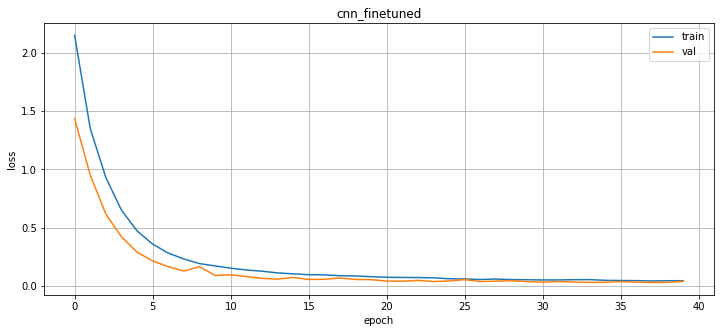

In [ ]:
plot_losses(train_losses_finetuned, val_losses_finetuned, title="cnn_finetuned")

In [ ]:
train_labels, train_probs, train_preds = collect_predictions(cnn_finetuned, dataloader_aug_train, device)

accuracy_train = accuracy_score(train_labels, train_preds)
accuracy_train

100%|██████████| 178/178 [00:34<00:00,  5.10it/s]


0.9858672752808989

In [ ]:
val_labels, val_probs, val_preds = collect_predictions(cnn_finetuned, dataloader_val, device)

accuracy_val = accuracy_score(val_labels, val_preds)
accuracy_val

  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 20/20 [00:01<00:00, 17.71it/s]


0.9925314465408805

In [ ]:
filenames_test = []
labels_test = []

with open("sampleSubmission.csv", "rt") as fp:
    fp.readline()
    for line in fp:
        fn, label = line.strip().split(',')
        filenames_test.append('test/'+fn)
        labels_test.append(int(label))

In [ ]:
dataset_test = SignsDataset(filenames_test, labels_test, "eval", transforms)

In [ ]:
dataloader_test = DataLoader(dataset_test, 
                            collate_fn=SignsDataset.collate_fn, 
                            batch_size=batch_size, shuffle=False, drop_last=False, 
                            num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
test_labels, test_probs, test_preds = collect_predictions(cnn_finetuned, dataloader_test, device)

100%|██████████| 59/59 [00:02<00:00, 22.91it/s]


In [ ]:
results = pd.read_csv("sampleSubmission.csv", index_col = "filename")

In [ ]:
results.class_number = test_preds

In [ ]:
results.to_csv("sampleSubmission_8.csv")

####Попробуем использовать другую модель

In [ ]:
resnet152 = M.resnet152(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
resnet152

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
x = torch.randn(1, 3, 224, 224)

y = resnet152(x)
y.size()

torch.Size([1, 1000])

In [ ]:
x = torch.randn(1, 3, 48, 48)

Например, можно взять и выдрать слои из модели и поместить в `Sequential`, приправив своими слоями сверху:

In [ ]:
cnn_finetuned = nn.Sequential(
    resnet152.conv1,
    resnet152.bn1,
    resnet152.relu,
    resnet152.maxpool,
    resnet152.layer1,
    resnet152.layer2,
    resnet152.layer3,
    resnet152.layer4,

    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(2048, 67)
)

In [ ]:
cnn_finetuned(x)

tensor([[-0.4790, -0.1650, -0.1103,  0.0582, -0.1521, -0.2050,  0.0946, -0.0474,
          0.0308,  0.3519, -0.0475,  0.0764, -0.3121,  0.3402, -0.2242,  0.0012,
         -0.4209, -0.0805,  0.3238,  0.1124, -0.0415,  0.0558,  0.1459,  0.1386,
          0.1358, -0.3734,  0.1385,  0.0745,  0.2214,  0.0544,  0.4696, -0.0528,
         -0.1637, -0.1607, -0.0188,  0.3833,  0.1762, -0.1863,  0.2975, -0.1026,
         -0.1157,  0.2817, -0.0721,  0.2711, -0.3533, -0.3814,  0.2430, -0.2295,
          0.1071,  0.1508, -0.3150, -0.4153,  0.0444,  0.2656,  0.1616, -0.1810,
         -0.1516, -0.4382, -0.2632, -0.3577,  0.0986, -0.1173, -0.0703,  0.4368,
         -0.4712,  0.0777,  0.1131]])

In [ ]:
cnn_finetuned[0].weight.requires_grad, cnn_finetuned[-1].weight.requires_grad

(True, True)

Веса слоев можно заморозить ручками:

In [ ]:
for layer in cnn_finetuned:
    layer.requires_grad_(False)

In [ ]:
cnn_finetuned[0].weight.requires_grad, cnn_finetuned[-1].weight.requires_grad

(False, False)

In [ ]:
cnn_finetuned[-1].requires_grad_(True)
cnn_finetuned[-1].weight.requires_grad

True

Теперь к обучению:

In [ ]:
num_epochs = 40
batch_size = 128
lr = 3e-4  # можно уменьшить

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


In [ ]:
loss_fn = nn.CrossEntropyLoss()

Сначала 5 эпох учим только последний слой:

In [ ]:
optimizer = torch.optim.Adam(cnn_finetuned[-1].parameters(), lr=lr)

In [ ]:
train_losses_finetuned, val_losses_finetuned, best_val_loss_finetuned, cnn_finetuned = run_experiment(
    cnn_finetuned, dataloader_aug_train, dataloader_val, loss_fn, optimizer, 5, device, "checkpoints_finetuned"
)

epoch: 000 | train:   0%|          | 0/178 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
epoch: 000 | train: 100%|██████████| 178/178 [00:46<00:00,  3.87it/s]
epoch: 000 | val  : 100%|██████████| 20/20 [00:01<00:00, 10.19it/s]


epoch: 000 | train_loss: 2.561, val_loss: 1.703 (best:   inf)
New checkpoint saved to checkpoints_finetuned/epoch=00_valloss=1.703.pth.tar



epoch: 001 | train: 100%|██████████| 178/178 [00:41<00:00,  4.25it/s]
epoch: 001 | val  : 100%|██████████| 20/20 [00:02<00:00,  8.24it/s]


epoch: 001 | train_loss: 1.877, val_loss: 1.380 (best: 1.703)
New checkpoint saved to checkpoints_finetuned/epoch=01_valloss=1.380.pth.tar



epoch: 002 | train: 100%|██████████| 178/178 [00:42<00:00,  4.18it/s]
epoch: 002 | val  : 100%|██████████| 20/20 [00:01<00:00, 10.12it/s]


epoch: 002 | train_loss: 1.689, val_loss: 1.230 (best: 1.380)
New checkpoint saved to checkpoints_finetuned/epoch=02_valloss=1.230.pth.tar



epoch: 003 | train: 100%|██████████| 178/178 [00:43<00:00,  4.10it/s]
epoch: 003 | val  : 100%|██████████| 20/20 [00:01<00:00, 10.28it/s]


epoch: 003 | train_loss: 1.584, val_loss: 1.164 (best: 1.230)
New checkpoint saved to checkpoints_finetuned/epoch=03_valloss=1.164.pth.tar



epoch: 004 | train: 100%|██████████| 178/178 [00:41<00:00,  4.24it/s]
epoch: 004 | val  : 100%|██████████| 20/20 [00:02<00:00,  7.79it/s]


epoch: 004 | train_loss: 1.522, val_loss: 1.096 (best: 1.164)
New checkpoint saved to checkpoints_finetuned/epoch=04_valloss=1.096.pth.tar

Best val_loss = 1.096 reached at epoch 4


Теперь размораживаем всю сеть и учим целиком:

In [ ]:
for layer in cnn_finetuned:
    layer.requires_grad_(True)

optimizer = torch.optim.Adam(cnn_finetuned.parameters(), lr=lr)    

In [ ]:
train_losses_finetuned, val_losses_finetuned, best_val_loss_finetuned, cnn_finetuned = run_experiment(
    cnn_finetuned, dataloader_aug_train, dataloader_val, loss_fn, optimizer, num_epochs, device, "checkpoints_finetuned"
)

epoch: 000 | train: 100%|██████████| 178/178 [01:03<00:00,  2.79it/s]
epoch: 000 | val  : 100%|██████████| 20/20 [00:01<00:00, 10.29it/s]


epoch: 000 | train_loss: 0.515, val_loss: 0.127 (best:   inf)
New checkpoint saved to checkpoints_finetuned/epoch=00_valloss=0.127.pth.tar



epoch: 001 | train: 100%|██████████| 178/178 [01:02<00:00,  2.85it/s]
epoch: 001 | val  : 100%|██████████| 20/20 [00:01<00:00, 10.16it/s]


epoch: 001 | train_loss: 0.221, val_loss: 0.131 (best: 0.127)



epoch: 002 | train: 100%|██████████| 178/178 [01:03<00:00,  2.83it/s]
epoch: 002 | val  : 100%|██████████| 20/20 [00:02<00:00,  8.33it/s]


epoch: 002 | train_loss: 0.164, val_loss: 0.111 (best: 0.127)
New checkpoint saved to checkpoints_finetuned/epoch=02_valloss=0.111.pth.tar



epoch: 003 | train: 100%|██████████| 178/178 [01:02<00:00,  2.85it/s]
epoch: 003 | val  : 100%|██████████| 20/20 [00:01<00:00, 10.16it/s]


epoch: 003 | train_loss: 0.127, val_loss: 0.061 (best: 0.111)
New checkpoint saved to checkpoints_finetuned/epoch=03_valloss=0.061.pth.tar



epoch: 004 | train: 100%|██████████| 178/178 [01:02<00:00,  2.86it/s]
epoch: 004 | val  : 100%|██████████| 20/20 [00:01<00:00, 10.19it/s]


epoch: 004 | train_loss: 0.117, val_loss: 0.054 (best: 0.061)
New checkpoint saved to checkpoints_finetuned/epoch=04_valloss=0.054.pth.tar



epoch: 005 | train: 100%|██████████| 178/178 [01:03<00:00,  2.78it/s]
epoch: 005 | val  : 100%|██████████| 20/20 [00:01<00:00, 10.21it/s]


epoch: 005 | train_loss: 0.105, val_loss: 0.053 (best: 0.054)
New checkpoint saved to checkpoints_finetuned/epoch=05_valloss=0.053.pth.tar



epoch: 006 | train: 100%|██████████| 178/178 [01:02<00:00,  2.85it/s]
epoch: 006 | val  : 100%|██████████| 20/20 [00:01<00:00, 10.16it/s]


epoch: 006 | train_loss: 0.091, val_loss: 0.059 (best: 0.053)



epoch: 007 | train: 100%|██████████| 178/178 [01:03<00:00,  2.81it/s]
epoch: 007 | val  : 100%|██████████| 20/20 [00:01<00:00, 10.01it/s]


epoch: 007 | train_loss: 0.091, val_loss: 0.089 (best: 0.053)



epoch: 008 | train: 100%|██████████| 178/178 [01:02<00:00,  2.86it/s]
epoch: 008 | val  : 100%|██████████| 20/20 [00:01<00:00, 10.31it/s]


epoch: 008 | train_loss: 0.094, val_loss: 0.033 (best: 0.053)
New checkpoint saved to checkpoints_finetuned/epoch=08_valloss=0.033.pth.tar



epoch: 009 | train: 100%|██████████| 178/178 [01:02<00:00,  2.83it/s]
epoch: 009 | val  : 100%|██████████| 20/20 [00:01<00:00, 10.38it/s]


epoch: 009 | train_loss: 0.075, val_loss: 0.063 (best: 0.033)



epoch: 010 | train: 100%|██████████| 178/178 [01:02<00:00,  2.83it/s]
epoch: 010 | val  : 100%|██████████| 20/20 [00:01<00:00, 10.26it/s]


epoch: 010 | train_loss: 0.071, val_loss: 0.041 (best: 0.033)



epoch: 011 | train: 100%|██████████| 178/178 [01:01<00:00,  2.88it/s]
epoch: 011 | val  : 100%|██████████| 20/20 [00:01<00:00, 10.40it/s]


epoch: 011 | train_loss: 0.063, val_loss: 0.058 (best: 0.033)



epoch: 012 | train: 100%|██████████| 178/178 [01:02<00:00,  2.84it/s]
epoch: 012 | val  : 100%|██████████| 20/20 [00:01<00:00, 10.24it/s]


epoch: 012 | train_loss: 0.067, val_loss: 0.033 (best: 0.033)



epoch: 013 | train: 100%|██████████| 178/178 [01:01<00:00,  2.88it/s]
epoch: 013 | val  : 100%|██████████| 20/20 [00:01<00:00, 10.55it/s]


epoch: 013 | train_loss: 0.060, val_loss: 0.048 (best: 0.033)



epoch: 014 | train: 100%|██████████| 178/178 [01:01<00:00,  2.89it/s]
epoch: 014 | val  : 100%|██████████| 20/20 [00:01<00:00, 10.47it/s]


epoch: 014 | train_loss: 0.064, val_loss: 0.056 (best: 0.033)



epoch: 015 | train: 100%|██████████| 178/178 [01:02<00:00,  2.84it/s]
epoch: 015 | val  : 100%|██████████| 20/20 [00:01<00:00, 10.41it/s]


epoch: 015 | train_loss: 0.093, val_loss: 0.046 (best: 0.033)



epoch: 016 | train: 100%|██████████| 178/178 [01:01<00:00,  2.91it/s]
epoch: 016 | val  : 100%|██████████| 20/20 [00:01<00:00, 10.53it/s]


epoch: 016 | train_loss: 0.062, val_loss: 0.129 (best: 0.033)



epoch: 017 | train: 100%|██████████| 178/178 [01:02<00:00,  2.86it/s]
epoch: 017 | val  : 100%|██████████| 20/20 [00:01<00:00, 10.50it/s]


epoch: 017 | train_loss: 0.059, val_loss: 0.039 (best: 0.033)



epoch: 018 | train: 100%|██████████| 178/178 [01:01<00:00,  2.89it/s]
epoch: 018 | val  : 100%|██████████| 20/20 [00:01<00:00, 10.50it/s]


epoch: 018 | train_loss: 0.052, val_loss: 0.040 (best: 0.033)



epoch: 019 | train: 100%|██████████| 178/178 [01:01<00:00,  2.89it/s]
epoch: 019 | val  : 100%|██████████| 20/20 [00:01<00:00, 10.39it/s]


epoch: 019 | train_loss: 0.054, val_loss: 0.037 (best: 0.033)



epoch: 020 | train: 100%|██████████| 178/178 [01:03<00:00,  2.82it/s]
epoch: 020 | val  : 100%|██████████| 20/20 [00:01<00:00, 10.29it/s]


epoch: 020 | train_loss: 0.053, val_loss: 0.037 (best: 0.033)



epoch: 021 | train: 100%|██████████| 178/178 [01:01<00:00,  2.89it/s]
epoch: 021 | val  : 100%|██████████| 20/20 [00:01<00:00, 10.38it/s]


epoch: 021 | train_loss: 0.047, val_loss: 0.037 (best: 0.033)



epoch: 022 | train: 100%|██████████| 178/178 [01:02<00:00,  2.83it/s]
epoch: 022 | val  : 100%|██████████| 20/20 [00:01<00:00, 10.06it/s]


epoch: 022 | train_loss: 0.048, val_loss: 0.055 (best: 0.033)



epoch: 023 | train: 100%|██████████| 178/178 [01:01<00:00,  2.89it/s]
epoch: 023 | val  : 100%|██████████| 20/20 [00:01<00:00, 10.08it/s]


epoch: 023 | train_loss: 0.046, val_loss: 0.035 (best: 0.033)



epoch: 024 | train: 100%|██████████| 178/178 [01:01<00:00,  2.89it/s]
epoch: 024 | val  : 100%|██████████| 20/20 [00:01<00:00, 10.03it/s]


epoch: 024 | train_loss: 0.044, val_loss: 0.031 (best: 0.033)
New checkpoint saved to checkpoints_finetuned/epoch=24_valloss=0.031.pth.tar



epoch: 025 | train: 100%|██████████| 178/178 [01:01<00:00,  2.89it/s]
epoch: 025 | val  : 100%|██████████| 20/20 [00:01<00:00, 10.36it/s]


epoch: 025 | train_loss: 0.047, val_loss: 0.037 (best: 0.031)



epoch: 026 | train: 100%|██████████| 178/178 [01:01<00:00,  2.87it/s]
epoch: 026 | val  : 100%|██████████| 20/20 [00:01<00:00, 10.26it/s]


epoch: 026 | train_loss: 0.041, val_loss: 0.032 (best: 0.031)



epoch: 027 | train: 100%|██████████| 178/178 [01:02<00:00,  2.83it/s]
epoch: 027 | val  : 100%|██████████| 20/20 [00:01<00:00, 10.45it/s]


epoch: 027 | train_loss: 0.042, val_loss: 0.032 (best: 0.031)



epoch: 028 | train: 100%|██████████| 178/178 [01:01<00:00,  2.89it/s]
epoch: 028 | val  : 100%|██████████| 20/20 [00:01<00:00, 10.32it/s]


epoch: 028 | train_loss: 0.042, val_loss: 0.037 (best: 0.031)



epoch: 029 | train: 100%|██████████| 178/178 [01:02<00:00,  2.84it/s]
epoch: 029 | val  : 100%|██████████| 20/20 [00:01<00:00, 10.34it/s]


epoch: 029 | train_loss: 0.039, val_loss: 0.038 (best: 0.031)



epoch: 030 | train: 100%|██████████| 178/178 [01:01<00:00,  2.88it/s]
epoch: 030 | val  : 100%|██████████| 20/20 [00:01<00:00, 10.20it/s]


epoch: 030 | train_loss: 0.039, val_loss: 0.032 (best: 0.031)



epoch: 031 | train: 100%|██████████| 178/178 [01:01<00:00,  2.87it/s]
epoch: 031 | val  : 100%|██████████| 20/20 [00:01<00:00, 10.27it/s]


epoch: 031 | train_loss: 0.048, val_loss: 0.031 (best: 0.031)
New checkpoint saved to checkpoints_finetuned/epoch=31_valloss=0.031.pth.tar



epoch: 032 | train: 100%|██████████| 178/178 [01:02<00:00,  2.85it/s]
epoch: 032 | val  : 100%|██████████| 20/20 [00:01<00:00, 10.41it/s]


epoch: 032 | train_loss: 0.038, val_loss: 0.025 (best: 0.031)
New checkpoint saved to checkpoints_finetuned/epoch=32_valloss=0.025.pth.tar



epoch: 033 | train: 100%|██████████| 178/178 [01:01<00:00,  2.89it/s]
epoch: 033 | val  : 100%|██████████| 20/20 [00:01<00:00, 10.31it/s]


epoch: 033 | train_loss: 0.044, val_loss: 0.039 (best: 0.025)



epoch: 034 | train: 100%|██████████| 178/178 [01:02<00:00,  2.83it/s]
epoch: 034 | val  : 100%|██████████| 20/20 [00:01<00:00, 10.20it/s]


epoch: 034 | train_loss: 0.043, val_loss: 0.055 (best: 0.025)



epoch: 035 | train: 100%|██████████| 178/178 [01:01<00:00,  2.87it/s]
epoch: 035 | val  : 100%|██████████| 20/20 [00:01<00:00, 10.12it/s]


epoch: 035 | train_loss: 0.036, val_loss: 0.035 (best: 0.025)



epoch: 036 | train: 100%|██████████| 178/178 [01:01<00:00,  2.88it/s]
epoch: 036 | val  : 100%|██████████| 20/20 [00:01<00:00, 10.21it/s]


epoch: 036 | train_loss: 0.038, val_loss: 0.038 (best: 0.025)



epoch: 037 | train: 100%|██████████| 178/178 [01:02<00:00,  2.84it/s]
epoch: 037 | val  : 100%|██████████| 20/20 [00:01<00:00, 10.40it/s]


epoch: 037 | train_loss: 0.037, val_loss: 0.028 (best: 0.025)



epoch: 038 | train: 100%|██████████| 178/178 [01:01<00:00,  2.89it/s]
epoch: 038 | val  : 100%|██████████| 20/20 [00:01<00:00, 10.25it/s]


epoch: 038 | train_loss: 0.037, val_loss: 0.027 (best: 0.025)



epoch: 039 | train: 100%|██████████| 178/178 [01:02<00:00,  2.86it/s]
epoch: 039 | val  : 100%|██████████| 20/20 [00:01<00:00, 10.18it/s]


epoch: 039 | train_loss: 0.034, val_loss: 0.028 (best: 0.025)

Best val_loss = 0.025 reached at epoch 32


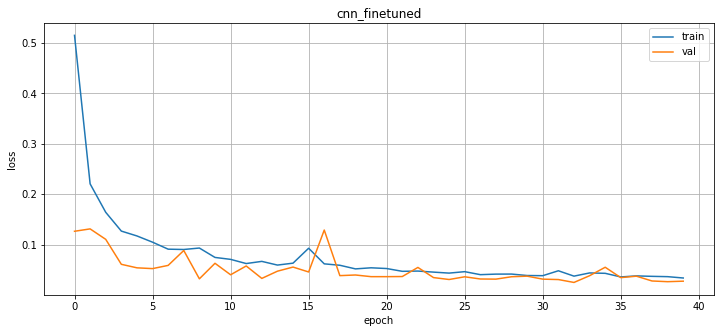

In [ ]:
plot_losses(train_losses_finetuned, val_losses_finetuned, title="cnn_finetuned")

In [ ]:
train_labels, train_probs, train_preds = collect_predictions(cnn_finetuned, dataloader_aug_train, device)

accuracy_train = accuracy_score(train_labels, train_preds)
accuracy_train

100%|██████████| 178/178 [00:39<00:00,  4.54it/s]


0.9886323735955056

In [ ]:
val_labels, val_probs, val_preds = collect_predictions(cnn_finetuned, dataloader_val, device)

accuracy_val = accuracy_score(val_labels, val_preds)
accuracy_val

  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 20/20 [00:02<00:00,  9.87it/s]


0.9921383647798742

In [ ]:
filenames_test = []
labels_test = []

with open("sampleSubmission.csv", "rt") as fp:
    fp.readline()
    for line in fp:
        fn, label = line.strip().split(',')
        filenames_test.append('test/'+fn)
        labels_test.append(int(label))

In [ ]:
dataset_test = SignsDataset(filenames_test, labels_test, "eval", transforms)

In [ ]:
dataloader_test = DataLoader(dataset_test, 
                            collate_fn=SignsDataset.collate_fn, 
                            batch_size=batch_size, shuffle=False, drop_last=False, 
                            num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
test_labels, test_probs, test_preds = collect_predictions(cnn_finetuned, dataloader_test, device)

100%|██████████| 59/59 [00:04<00:00, 12.12it/s]


In [ ]:
results = pd.read_csv("sampleSubmission.csv", index_col = "filename")

In [ ]:
results.class_number = test_preds

In [ ]:
results.to_csv("sampleSubmission_9.csv")

### LR scheduling

Последняя на сегодня - работа с LR.
Из лекций вы могли запомнить, что варьирование LR при обучении (даже адаптивных методов) может достичь более высокого качества.

![lrs](https://i.stack.imgur.com/UHYMw.png)

`pytorch` предоставляет возможности и для этого.

##### Обновление по сигналу от метрик (ReduceLROnPlateau)

Можно изменять LR, основываясь на изменении целевой метрики.
Если, например, лосс давно не падает, можно уменьшить LR:

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
cnn_aug = nn.Sequential(
    CNNBlock(3, 64),
    CNNBlock(64, 128),
    CNNBlock(128, 256),
    CNNBlock(256, 512),
    CNNBlock(512, 1024),

    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(1024, 67)
)

In [ ]:
num_epochs = 40
batch_size = 128
lr = 3e-4

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


In [ ]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(cnn_aug.parameters(), lr=lr)

scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=1, verbose=True)

In [ ]:
def run_epoch(stage, model, dataloader, loss_fn, optimizer, epoch, device):

    if stage == "train":
        model.train()
        torch.set_grad_enabled(True)
    else:
        torch.set_grad_enabled(False)
        model.eval()

    model = model.to(device)
    
    losses = []
    for batch in tqdm(dataloader, total=len(dataloader), desc=f"epoch: {str(epoch).zfill(3)} | {stage:5}"):
        xs, ys_true = batch
                
        ys_pred = model(xs.to(device))
        loss = loss_fn(ys_pred, ys_true.to(device))

        if stage == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
                
        losses.append(loss.detach().cpu().item())
    
    if stage == "train":
        scheduler.step(np.mean(losses))

    return np.mean(losses)

In [ ]:
dataloader_aug_train = DataLoader(dataset_aug_train, 
                                  collate_fn=SignsDataset.collate_fn, 
                                  batch_size=batch_size, shuffle=True, drop_last=True, 
                                  num_workers=4, pin_memory=True)

dataloader_val = DataLoader(dataset_val, 
                            collate_fn=SignsDataset.collate_fn, 
                            batch_size=batch_size, shuffle=False, drop_last=False, 
                            num_workers=4, pin_memory=True)

In [ ]:
train_losses_aug, val_losses_aug, best_val_loss_aug, cnn_aug = run_experiment(
    cnn_aug, dataloader_aug_train, dataloader_val, loss_fn, optimizer, num_epochs, device, "checkpoints_aug"
)

epoch: 000 | train: 100%|██████████| 178/178 [00:40<00:00,  4.44it/s]
epoch: 000 | val  : 100%|██████████| 20/20 [00:01<00:00, 16.29it/s]


epoch: 000 | train_loss: 1.695, val_loss: 0.423 (best:   inf)
New checkpoint saved to checkpoints_aug/epoch=00_valloss=0.423.pth.tar



epoch: 001 | train: 100%|██████████| 178/178 [00:38<00:00,  4.60it/s]
epoch: 001 | val  : 100%|██████████| 20/20 [00:01<00:00, 16.03it/s]


epoch: 001 | train_loss: 0.419, val_loss: 0.187 (best: 0.423)
New checkpoint saved to checkpoints_aug/epoch=01_valloss=0.187.pth.tar



epoch: 002 | train: 100%|██████████| 178/178 [00:39<00:00,  4.47it/s]
epoch: 002 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.42it/s]


epoch: 002 | train_loss: 0.246, val_loss: 0.127 (best: 0.187)
New checkpoint saved to checkpoints_aug/epoch=02_valloss=0.127.pth.tar



epoch: 003 | train: 100%|██████████| 178/178 [00:39<00:00,  4.52it/s]
epoch: 003 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.70it/s]


epoch: 003 | train_loss: 0.183, val_loss: 0.117 (best: 0.127)
New checkpoint saved to checkpoints_aug/epoch=03_valloss=0.117.pth.tar



epoch: 004 | train: 100%|██████████| 178/178 [00:39<00:00,  4.50it/s]
epoch: 004 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.15it/s]


epoch: 004 | train_loss: 0.154, val_loss: 0.084 (best: 0.117)
New checkpoint saved to checkpoints_aug/epoch=04_valloss=0.084.pth.tar



epoch: 005 | train: 100%|██████████| 178/178 [00:38<00:00,  4.61it/s]
epoch: 005 | val  : 100%|██████████| 20/20 [00:01<00:00, 16.01it/s]


epoch: 005 | train_loss: 0.131, val_loss: 0.059 (best: 0.084)
New checkpoint saved to checkpoints_aug/epoch=05_valloss=0.059.pth.tar



epoch: 006 | train: 100%|██████████| 178/178 [00:38<00:00,  4.59it/s]
epoch: 006 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.40it/s]


epoch: 006 | train_loss: 0.118, val_loss: 0.047 (best: 0.059)
New checkpoint saved to checkpoints_aug/epoch=06_valloss=0.047.pth.tar



epoch: 007 | train: 100%|██████████| 178/178 [00:38<00:00,  4.64it/s]
epoch: 007 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.81it/s]


epoch: 007 | train_loss: 0.105, val_loss: 0.058 (best: 0.047)



epoch: 008 | train: 100%|██████████| 178/178 [00:39<00:00,  4.53it/s]
epoch: 008 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.67it/s]


epoch: 008 | train_loss: 0.094, val_loss: 0.052 (best: 0.047)



epoch: 009 | train: 100%|██████████| 178/178 [00:39<00:00,  4.52it/s]
epoch: 009 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.32it/s]


epoch: 009 | train_loss: 0.092, val_loss: 0.048 (best: 0.047)



epoch: 010 | train: 100%|██████████| 178/178 [00:40<00:00,  4.38it/s]
epoch: 010 | val  : 100%|██████████| 20/20 [00:01<00:00, 14.96it/s]


epoch: 010 | train_loss: 0.081, val_loss: 0.047 (best: 0.047)
New checkpoint saved to checkpoints_aug/epoch=10_valloss=0.047.pth.tar



epoch: 011 | train: 100%|██████████| 178/178 [00:39<00:00,  4.51it/s]
epoch: 011 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.43it/s]


epoch: 011 | train_loss: 0.082, val_loss: 0.041 (best: 0.047)
New checkpoint saved to checkpoints_aug/epoch=11_valloss=0.041.pth.tar



epoch: 012 | train: 100%|██████████| 178/178 [00:39<00:00,  4.51it/s]
epoch: 012 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.70it/s]


epoch: 012 | train_loss: 0.072, val_loss: 0.041 (best: 0.041)
New checkpoint saved to checkpoints_aug/epoch=12_valloss=0.041.pth.tar



epoch: 013 | train: 100%|██████████| 178/178 [00:38<00:00,  4.57it/s]
epoch: 013 | val  : 100%|██████████| 20/20 [00:01<00:00, 16.25it/s]


epoch: 013 | train_loss: 0.066, val_loss: 0.046 (best: 0.041)



epoch: 014 | train: 100%|██████████| 178/178 [00:39<00:00,  4.48it/s]
epoch: 014 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.73it/s]


epoch: 014 | train_loss: 0.066, val_loss: 0.080 (best: 0.041)



epoch: 015 | train: 100%|██████████| 178/178 [00:39<00:00,  4.56it/s]
epoch: 015 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.37it/s]


epoch: 015 | train_loss: 0.069, val_loss: 0.045 (best: 0.041)



epoch: 016 | train: 100%|██████████| 178/178 [00:38<00:00,  4.58it/s]
epoch: 016 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.41it/s]


epoch: 016 | train_loss: 0.060, val_loss: 0.037 (best: 0.041)
New checkpoint saved to checkpoints_aug/epoch=16_valloss=0.037.pth.tar



epoch: 017 | train: 100%|██████████| 178/178 [00:39<00:00,  4.54it/s]
epoch: 017 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.55it/s]


epoch: 017 | train_loss: 0.059, val_loss: 0.048 (best: 0.037)



epoch: 018 | train: 100%|██████████| 178/178 [00:40<00:00,  4.43it/s]
epoch: 018 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.88it/s]


epoch: 018 | train_loss: 0.060, val_loss: 0.041 (best: 0.037)



epoch: 019 | train: 100%|██████████| 178/178 [00:39<00:00,  4.55it/s]


Epoch 00020: reducing learning rate of group 0 to 1.5000e-04.


epoch: 019 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.63it/s]


epoch: 019 | train_loss: 0.060, val_loss: 0.031 (best: 0.037)
New checkpoint saved to checkpoints_aug/epoch=19_valloss=0.031.pth.tar



epoch: 020 | train: 100%|██████████| 178/178 [00:39<00:00,  4.51it/s]
epoch: 020 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.55it/s]


epoch: 020 | train_loss: 0.035, val_loss: 0.014 (best: 0.031)
New checkpoint saved to checkpoints_aug/epoch=20_valloss=0.014.pth.tar



epoch: 021 | train: 100%|██████████| 178/178 [00:39<00:00,  4.55it/s]
epoch: 021 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.37it/s]


epoch: 021 | train_loss: 0.032, val_loss: 0.017 (best: 0.014)



epoch: 022 | train: 100%|██████████| 178/178 [00:40<00:00,  4.42it/s]
epoch: 022 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.76it/s]


epoch: 022 | train_loss: 0.029, val_loss: 0.014 (best: 0.014)



epoch: 023 | train: 100%|██████████| 178/178 [00:39<00:00,  4.50it/s]
epoch: 023 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.61it/s]


epoch: 023 | train_loss: 0.029, val_loss: 0.016 (best: 0.014)



epoch: 024 | train: 100%|██████████| 178/178 [00:39<00:00,  4.46it/s]
epoch: 024 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.28it/s]


epoch: 024 | train_loss: 0.029, val_loss: 0.017 (best: 0.014)



epoch: 025 | train: 100%|██████████| 178/178 [00:39<00:00,  4.49it/s]
epoch: 025 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.00it/s]


epoch: 025 | train_loss: 0.028, val_loss: 0.018 (best: 0.014)



epoch: 026 | train: 100%|██████████| 178/178 [00:41<00:00,  4.31it/s]
epoch: 026 | val  : 100%|██████████| 20/20 [00:01<00:00, 14.66it/s]


epoch: 026 | train_loss: 0.028, val_loss: 0.016 (best: 0.014)



epoch: 027 | train: 100%|██████████| 178/178 [00:39<00:00,  4.51it/s]


Epoch 00028: reducing learning rate of group 0 to 7.5000e-05.


epoch: 027 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.71it/s]


epoch: 027 | train_loss: 0.028, val_loss: 0.020 (best: 0.014)



epoch: 028 | train: 100%|██████████| 178/178 [00:39<00:00,  4.48it/s]
epoch: 028 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.26it/s]


epoch: 028 | train_loss: 0.020, val_loss: 0.011 (best: 0.014)
New checkpoint saved to checkpoints_aug/epoch=28_valloss=0.011.pth.tar



epoch: 029 | train: 100%|██████████| 178/178 [00:40<00:00,  4.43it/s]
epoch: 029 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.70it/s]


epoch: 029 | train_loss: 0.018, val_loss: 0.015 (best: 0.011)



epoch: 030 | train: 100%|██████████| 178/178 [00:40<00:00,  4.38it/s]
epoch: 030 | val  : 100%|██████████| 20/20 [00:01<00:00, 14.79it/s]


epoch: 030 | train_loss: 0.017, val_loss: 0.013 (best: 0.011)



epoch: 031 | train: 100%|██████████| 178/178 [00:39<00:00,  4.47it/s]
epoch: 031 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.95it/s]


epoch: 031 | train_loss: 0.015, val_loss: 0.013 (best: 0.011)



epoch: 032 | train: 100%|██████████| 178/178 [00:39<00:00,  4.52it/s]
epoch: 032 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.31it/s]


epoch: 032 | train_loss: 0.019, val_loss: 0.014 (best: 0.011)



epoch: 033 | train: 100%|██████████| 178/178 [00:39<00:00,  4.47it/s]


Epoch 00034: reducing learning rate of group 0 to 3.7500e-05.


epoch: 033 | val  : 100%|██████████| 20/20 [00:01<00:00, 16.02it/s]


epoch: 033 | train_loss: 0.016, val_loss: 0.011 (best: 0.011)
New checkpoint saved to checkpoints_aug/epoch=33_valloss=0.011.pth.tar



epoch: 034 | train: 100%|██████████| 178/178 [00:40<00:00,  4.36it/s]
epoch: 034 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.38it/s]


epoch: 034 | train_loss: 0.013, val_loss: 0.013 (best: 0.011)



epoch: 035 | train: 100%|██████████| 178/178 [00:39<00:00,  4.49it/s]
epoch: 035 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.92it/s]


epoch: 035 | train_loss: 0.010, val_loss: 0.011 (best: 0.011)



epoch: 036 | train: 100%|██████████| 178/178 [00:39<00:00,  4.48it/s]
epoch: 036 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.32it/s]


epoch: 036 | train_loss: 0.011, val_loss: 0.014 (best: 0.011)



epoch: 037 | train: 100%|██████████| 178/178 [00:40<00:00,  4.45it/s]


Epoch 00038: reducing learning rate of group 0 to 1.8750e-05.


epoch: 037 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.01it/s]


epoch: 037 | train_loss: 0.011, val_loss: 0.013 (best: 0.011)



epoch: 038 | train: 100%|██████████| 178/178 [00:41<00:00,  4.30it/s]
epoch: 038 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.29it/s]


epoch: 038 | train_loss: 0.009, val_loss: 0.013 (best: 0.011)



epoch: 039 | train: 100%|██████████| 178/178 [00:39<00:00,  4.45it/s]
epoch: 039 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.28it/s]


epoch: 039 | train_loss: 0.009, val_loss: 0.013 (best: 0.011)

Best val_loss = 0.011 reached at epoch 33


In [ ]:
filenames_test = []
labels_test = []

with open("sampleSubmission.csv", "rt") as fp:
    fp.readline()
    for line in fp:
        fn, label = line.strip().split(',')
        filenames_test.append('test/'+fn)
        labels_test.append(int(label))

In [ ]:
dataset_test = SignsDataset(filenames_test, labels_test, "eval", transforms)

In [ ]:
dataloader_test = DataLoader(dataset_test, 
                            collate_fn=SignsDataset.collate_fn, 
                            batch_size=batch_size, shuffle=False, drop_last=False, 
                            num_workers=4, pin_memory=True)

In [ ]:
test_labels, test_probs, test_preds = collect_predictions(cnn_aug, dataloader_test, device)

100%|██████████| 59/59 [00:02<00:00, 19.68it/s]


In [ ]:
results = pd.read_csv("sampleSubmission.csv", index_col = "filename")

In [ ]:
results.class_number = test_preds

In [ ]:
results.to_csv("sampleSubmission_10.csv")

#### Другой способ изменения lr

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR

In [ ]:
cnn_aug = nn.Sequential(
    CNNBlock(3, 64),
    CNNBlock(64, 128),
    CNNBlock(128, 256),
    CNNBlock(256, 512),
    CNNBlock(512, 1024),

    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(1024, 67)
)

In [ ]:
num_epochs = 50
batch_size = 256
lr = 3e-4

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


In [ ]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(cnn_aug.parameters(), lr=lr)

scheduler = CosineAnnealingLR(optimizer, T_max=int(len(dataloader_aug_train) + 1) * num_epochs)

In [ ]:
def run_epoch(stage, model, dataloader, loss_fn, optimizer, epoch, device):

    if stage == "train":
        model.train()
        torch.set_grad_enabled(True)
        print("lr (epoch start):", scheduler.optimizer.param_groups[0]['lr'])
    else:
        torch.set_grad_enabled(False)
        model.eval()

    model = model.to(device)
    
    
    losses = []
    for batch in tqdm(dataloader, total=len(dataloader), desc=f"epoch: {str(epoch).zfill(3)} | {stage:5}"):
        xs, ys_true = batch
                
        ys_pred = model(xs.to(device))
        loss = loss_fn(ys_pred, ys_true.to(device))

        if stage == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()
            
        losses.append(loss.detach().cpu().item())
    
    if stage == "train":
        print("lr (epoch end):", scheduler.optimizer.param_groups[0]['lr'])

    return np.mean(losses)

In [ ]:
train_losses_aug, val_losses_aug, best_val_loss_aug, cnn_aug = run_experiment(
    cnn_aug, dataloader_aug_train, dataloader_val, loss_fn, optimizer, num_epochs, device, "checkpoints_aug"
)

lr (epoch start): 0.0003


epoch: 000 | train: 100%|██████████| 178/178 [00:38<00:00,  4.62it/s]


lr (epoch end): 0.00029970730611246927


epoch: 000 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.52it/s]


epoch: 000 | train_loss: 1.552, val_loss: 0.338 (best:   inf)
New checkpoint saved to checkpoints_aug/epoch=00_valloss=0.338.pth.tar

lr (epoch start): 0.00029970730611246927


epoch: 001 | train: 100%|██████████| 178/178 [00:39<00:00,  4.55it/s]


lr (epoch end): 0.00029883036671270055


epoch: 001 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.46it/s]


epoch: 001 | train_loss: 0.376, val_loss: 0.155 (best: 0.338)
New checkpoint saved to checkpoints_aug/epoch=01_valloss=0.155.pth.tar

lr (epoch start): 0.00029883036671270055


epoch: 002 | train: 100%|██████████| 178/178 [00:38<00:00,  4.66it/s]


lr (epoch end): 0.00029737260413138745


epoch: 002 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.44it/s]


epoch: 002 | train_loss: 0.242, val_loss: 0.106 (best: 0.155)
New checkpoint saved to checkpoints_aug/epoch=02_valloss=0.106.pth.tar

lr (epoch start): 0.00029737260413138745


epoch: 003 | train: 100%|██████████| 178/178 [00:37<00:00,  4.70it/s]


lr (epoch end): 0.0002953397074111578


epoch: 003 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.09it/s]


epoch: 003 | train_loss: 0.176, val_loss: 0.092 (best: 0.106)
New checkpoint saved to checkpoints_aug/epoch=03_valloss=0.092.pth.tar

lr (epoch start): 0.0002953397074111578


epoch: 004 | train: 100%|██████████| 178/178 [00:38<00:00,  4.68it/s]


lr (epoch end): 0.00029273961010459687


epoch: 004 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.54it/s]


epoch: 004 | train_loss: 0.151, val_loss: 0.092 (best: 0.092)

lr (epoch start): 0.00029273961010459687


epoch: 005 | train: 100%|██████████| 178/178 [00:39<00:00,  4.50it/s]


lr (epoch end): 0.00028958245931288756


epoch: 005 | val  : 100%|██████████| 20/20 [00:01<00:00, 16.11it/s]


epoch: 005 | train_loss: 0.126, val_loss: 0.058 (best: 0.092)
New checkpoint saved to checkpoints_aug/epoch=05_valloss=0.058.pth.tar

lr (epoch start): 0.00028958245931288756


epoch: 006 | train: 100%|██████████| 178/178 [00:37<00:00,  4.68it/s]


lr (epoch end): 0.00028588057608587895


epoch: 006 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.88it/s]


epoch: 006 | train_loss: 0.118, val_loss: 0.080 (best: 0.058)

lr (epoch start): 0.00028588057608587895


epoch: 007 | train: 100%|██████████| 178/178 [00:38<00:00,  4.65it/s]


lr (epoch end): 0.00028164840733814304


epoch: 007 | val  : 100%|██████████| 20/20 [00:01<00:00, 16.14it/s]


epoch: 007 | train_loss: 0.099, val_loss: 0.051 (best: 0.058)
New checkpoint saved to checkpoints_aug/epoch=07_valloss=0.051.pth.tar

lr (epoch start): 0.00028164840733814304


epoch: 008 | train: 100%|██████████| 178/178 [00:38<00:00,  4.63it/s]


lr (epoch end): 0.0002769024694686597


epoch: 008 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.90it/s]


epoch: 008 | train_loss: 0.094, val_loss: 0.047 (best: 0.051)
New checkpoint saved to checkpoints_aug/epoch=08_valloss=0.047.pth.tar

lr (epoch start): 0.0002769024694686597


epoch: 009 | train: 100%|██████████| 178/178 [00:38<00:00,  4.68it/s]


lr (epoch end): 0.0002716612839041624


epoch: 009 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.69it/s]


epoch: 009 | train_loss: 0.081, val_loss: 0.046 (best: 0.047)
New checkpoint saved to checkpoints_aug/epoch=09_valloss=0.046.pth.tar

lr (epoch start): 0.0002716612839041624


epoch: 010 | train: 100%|██████████| 178/178 [00:39<00:00,  4.53it/s]


lr (epoch end): 0.00026594530481769297


epoch: 010 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.86it/s]


epoch: 010 | train_loss: 0.071, val_loss: 0.056 (best: 0.046)

lr (epoch start): 0.00026594530481769297


epoch: 011 | train: 100%|██████████| 178/178 [00:37<00:00,  4.70it/s]


lr (epoch end): 0.00025977683930444943


epoch: 011 | val  : 100%|██████████| 20/20 [00:01<00:00, 14.92it/s]


epoch: 011 | train_loss: 0.077, val_loss: 0.058 (best: 0.046)

lr (epoch start): 0.00025977683930444943


epoch: 012 | train: 100%|██████████| 178/178 [00:37<00:00,  4.69it/s]


lr (epoch end): 0.0002531799603264473


epoch: 012 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.85it/s]


epoch: 012 | train_loss: 0.069, val_loss: 0.039 (best: 0.046)
New checkpoint saved to checkpoints_aug/epoch=12_valloss=0.039.pth.tar

lr (epoch start): 0.0002531799603264473


epoch: 013 | train: 100%|██████████| 178/178 [00:37<00:00,  4.74it/s]


lr (epoch end): 0.00024618041276573514


epoch: 013 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.29it/s]


epoch: 013 | train_loss: 0.063, val_loss: 0.050 (best: 0.039)

lr (epoch start): 0.00024618041276573514


epoch: 014 | train: 100%|██████████| 178/178 [00:39<00:00,  4.50it/s]


lr (epoch end): 0.00023880551295280003


epoch: 014 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.87it/s]


epoch: 014 | train_loss: 0.053, val_loss: 0.023 (best: 0.039)
New checkpoint saved to checkpoints_aug/epoch=14_valloss=0.023.pth.tar

lr (epoch start): 0.00023880551295280003


epoch: 015 | train: 100%|██████████| 178/178 [00:37<00:00,  4.72it/s]


lr (epoch end): 0.00023108404206226036


epoch: 015 | val  : 100%|██████████| 20/20 [00:01<00:00, 16.11it/s]


epoch: 015 | train_loss: 0.060, val_loss: 0.027 (best: 0.023)

lr (epoch start): 0.00023108404206226036


epoch: 016 | train: 100%|██████████| 178/178 [00:38<00:00,  4.66it/s]


lr (epoch end): 0.00022304613379188173


epoch: 016 | val  : 100%|██████████| 20/20 [00:01<00:00, 16.07it/s]


epoch: 016 | train_loss: 0.051, val_loss: 0.037 (best: 0.023)

lr (epoch start): 0.00022304613379188173


epoch: 017 | train: 100%|██████████| 178/178 [00:38<00:00,  4.67it/s]


lr (epoch end): 0.00021472315676325442


epoch: 017 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.97it/s]


epoch: 017 | train_loss: 0.055, val_loss: 0.028 (best: 0.023)

lr (epoch start): 0.00021472315676325442


epoch: 018 | train: 100%|██████████| 178/178 [00:39<00:00,  4.53it/s]


lr (epoch end): 0.00020614759210307618


epoch: 018 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.80it/s]


epoch: 018 | train_loss: 0.046, val_loss: 0.021 (best: 0.023)
New checkpoint saved to checkpoints_aug/epoch=18_valloss=0.021.pth.tar

lr (epoch start): 0.00020614759210307618


epoch: 019 | train: 100%|██████████| 178/178 [00:37<00:00,  4.71it/s]


lr (epoch end): 0.0001973529066827893


epoch: 019 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.56it/s]


epoch: 019 | train_loss: 0.041, val_loss: 0.029 (best: 0.021)

lr (epoch start): 0.0001973529066827893


epoch: 020 | train: 100%|██████████| 178/178 [00:37<00:00,  4.69it/s]


lr (epoch end): 0.00018837342251126418


epoch: 020 | val  : 100%|██████████| 20/20 [00:01<00:00, 16.11it/s]


epoch: 020 | train_loss: 0.043, val_loss: 0.029 (best: 0.021)

lr (epoch start): 0.00018837342251126418


epoch: 021 | train: 100%|██████████| 178/178 [00:38<00:00,  4.65it/s]


lr (epoch end): 0.00017924418279023646


epoch: 021 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.71it/s]


epoch: 021 | train_loss: 0.042, val_loss: 0.026 (best: 0.021)

lr (epoch start): 0.00017924418279023646


epoch: 022 | train: 100%|██████████| 178/178 [00:38<00:00,  4.63it/s]


lr (epoch end): 0.00017000081515522803


epoch: 022 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.46it/s]


epoch: 022 | train_loss: 0.039, val_loss: 0.030 (best: 0.021)

lr (epoch start): 0.00017000081515522803


epoch: 023 | train: 100%|██████████| 178/178 [00:39<00:00,  4.53it/s]


lr (epoch end): 0.00016067939263566527


epoch: 023 | val  : 100%|██████████| 20/20 [00:01<00:00, 14.75it/s]


epoch: 023 | train_loss: 0.036, val_loss: 0.028 (best: 0.021)

lr (epoch start): 0.00016067939263566527


epoch: 024 | train: 100%|██████████| 178/178 [00:38<00:00,  4.60it/s]


lr (epoch end): 0.0001513162928768094


epoch: 024 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.65it/s]


epoch: 024 | train_loss: 0.032, val_loss: 0.027 (best: 0.021)

lr (epoch start): 0.0001513162928768094


epoch: 025 | train: 100%|██████████| 178/178 [00:38<00:00,  4.67it/s]


lr (epoch end): 0.00014194805617289688


epoch: 025 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.05it/s]


epoch: 025 | train_loss: 0.029, val_loss: 0.024 (best: 0.021)

lr (epoch start): 0.00014194805617289688


epoch: 026 | train: 100%|██████████| 178/178 [00:37<00:00,  4.75it/s]


lr (epoch end): 0.00013261124286552983


epoch: 026 | val  : 100%|██████████| 20/20 [00:01<00:00, 16.06it/s]


epoch: 026 | train_loss: 0.029, val_loss: 0.017 (best: 0.021)
New checkpoint saved to checkpoints_aug/epoch=26_valloss=0.017.pth.tar

lr (epoch start): 0.00013261124286552983


epoch: 027 | train: 100%|██████████| 178/178 [00:38<00:00,  4.65it/s]


lr (epoch end): 0.00012334229066382997


epoch: 027 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.97it/s]


epoch: 027 | train_loss: 0.025, val_loss: 0.022 (best: 0.017)

lr (epoch start): 0.00012334229066382997


epoch: 028 | train: 100%|██████████| 178/178 [00:38<00:00,  4.68it/s]


lr (epoch end): 0.00011417737244317377


epoch: 028 | val  : 100%|██████████| 20/20 [00:01<00:00, 16.17it/s]


epoch: 028 | train_loss: 0.021, val_loss: 0.017 (best: 0.017)
New checkpoint saved to checkpoints_aug/epoch=28_valloss=0.017.pth.tar

lr (epoch start): 0.00011417737244317377


epoch: 029 | train: 100%|██████████| 178/178 [00:37<00:00,  4.69it/s]


lr (epoch end): 0.00010515225507746651


epoch: 029 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.63it/s]


epoch: 029 | train_loss: 0.023, val_loss: 0.019 (best: 0.017)

lr (epoch start): 0.00010515225507746651


epoch: 030 | train: 100%|██████████| 178/178 [00:37<00:00,  4.70it/s]


lr (epoch end): 9.630215985587096e-05


epoch: 030 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.85it/s]


epoch: 030 | train_loss: 0.023, val_loss: 0.020 (best: 0.017)

lr (epoch start): 9.630215985587096e-05


epoch: 031 | train: 100%|██████████| 178/178 [00:37<00:00,  4.71it/s]


lr (epoch end): 8.766162502872614e-05


epoch: 031 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.60it/s]


epoch: 031 | train_loss: 0.018, val_loss: 0.017 (best: 0.017)
New checkpoint saved to checkpoints_aug/epoch=31_valloss=0.017.pth.tar

lr (epoch start): 8.766162502872614e-05


epoch: 032 | train: 100%|██████████| 178/178 [00:38<00:00,  4.57it/s]


lr (epoch end): 7.926437101908425e-05


epoch: 032 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.45it/s]


epoch: 032 | train_loss: 0.019, val_loss: 0.021 (best: 0.017)

lr (epoch start): 7.926437101908425e-05


epoch: 033 | train: 100%|██████████| 178/178 [00:37<00:00,  4.74it/s]


lr (epoch end): 7.114316882588721e-05


epoch: 033 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.68it/s]


epoch: 033 | train_loss: 0.020, val_loss: 0.018 (best: 0.017)

lr (epoch start): 7.114316882588721e-05


epoch: 034 | train: 100%|██████████| 178/178 [00:38<00:00,  4.67it/s]


lr (epoch end): 6.332971213235321e-05


epoch: 034 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.59it/s]


epoch: 034 | train_loss: 0.015, val_loss: 0.019 (best: 0.017)

lr (epoch start): 6.332971213235321e-05


epoch: 035 | train: 100%|██████████| 178/178 [00:37<00:00,  4.73it/s]


lr (epoch end): 5.585449361867794e-05


epoch: 035 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.65it/s]


epoch: 035 | train_loss: 0.015, val_loss: 0.018 (best: 0.017)

lr (epoch start): 5.585449361867794e-05


epoch: 036 | train: 100%|██████████| 178/178 [00:39<00:00,  4.55it/s]


lr (epoch end): 4.8746685961753624e-05


epoch: 036 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.75it/s]


epoch: 036 | train_loss: 0.013, val_loss: 0.016 (best: 0.017)
New checkpoint saved to checkpoints_aug/epoch=36_valloss=0.016.pth.tar

lr (epoch start): 4.8746685961753624e-05


epoch: 037 | train: 100%|██████████| 178/178 [00:37<00:00,  4.73it/s]


lr (epoch end): 4.2034027986312647e-05


epoch: 037 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.72it/s]


epoch: 037 | train_loss: 0.012, val_loss: 0.018 (best: 0.016)

lr (epoch start): 4.2034027986312647e-05


epoch: 038 | train: 100%|██████████| 178/178 [00:37<00:00,  4.74it/s]


lr (epoch end): 3.574271641180164e-05


epoch: 038 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.89it/s]


epoch: 038 | train_loss: 0.012, val_loss: 0.015 (best: 0.016)
New checkpoint saved to checkpoints_aug/epoch=38_valloss=0.015.pth.tar

lr (epoch start): 3.574271641180164e-05


epoch: 039 | train: 100%|██████████| 178/178 [00:37<00:00,  4.74it/s]


lr (epoch end): 2.9897303617452847e-05


epoch: 039 | val  : 100%|██████████| 20/20 [00:01<00:00, 16.13it/s]


epoch: 039 | train_loss: 0.012, val_loss: 0.016 (best: 0.015)

lr (epoch start): 2.9897303617452847e-05


epoch: 040 | train: 100%|██████████| 178/178 [00:37<00:00,  4.71it/s]


lr (epoch end): 2.4520601824532828e-05


epoch: 040 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.19it/s]


epoch: 040 | train_loss: 0.008, val_loss: 0.014 (best: 0.015)
New checkpoint saved to checkpoints_aug/epoch=40_valloss=0.014.pth.tar

lr (epoch start): 2.4520601824532828e-05


epoch: 041 | train: 100%|██████████| 178/178 [00:39<00:00,  4.56it/s]


lr (epoch end): 1.9633594069706486e-05


epoch: 041 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.68it/s]


epoch: 041 | train_loss: 0.008, val_loss: 0.017 (best: 0.014)

lr (epoch start): 1.9633594069706486e-05


epoch: 042 | train: 100%|██████████| 178/178 [00:37<00:00,  4.76it/s]


lr (epoch end): 1.5255352316949227e-05


epoch: 042 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.43it/s]


epoch: 042 | train_loss: 0.009, val_loss: 0.014 (best: 0.014)

lr (epoch start): 1.5255352316949227e-05


epoch: 043 | train: 100%|██████████| 178/178 [00:37<00:00,  4.70it/s]


lr (epoch end): 1.1402963027583234e-05


epoch: 043 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.54it/s]


epoch: 043 | train_loss: 0.006, val_loss: 0.015 (best: 0.014)

lr (epoch start): 1.1402963027583234e-05


epoch: 044 | train: 100%|██████████| 178/178 [00:37<00:00,  4.77it/s]


lr (epoch end): 8.091460478907013e-06


epoch: 044 | val  : 100%|██████████| 20/20 [00:01<00:00, 16.14it/s]


epoch: 044 | train_loss: 0.009, val_loss: 0.015 (best: 0.014)

lr (epoch start): 8.091460478907013e-06


epoch: 045 | train: 100%|██████████| 178/178 [00:38<00:00,  4.57it/s]


lr (epoch end): 5.333768091647811e-06


epoch: 045 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.73it/s]


epoch: 045 | train_loss: 0.006, val_loss: 0.014 (best: 0.014)

lr (epoch start): 5.333768091647811e-06


epoch: 046 | train: 100%|██████████| 178/178 [00:39<00:00,  4.55it/s]


lr (epoch end): 3.140647995211439e-06


epoch: 046 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.68it/s]


epoch: 046 | train_loss: 0.007, val_loss: 0.014 (best: 0.014)

lr (epoch start): 3.140647995211439e-06


epoch: 047 | train: 100%|██████████| 178/178 [00:37<00:00,  4.69it/s]


lr (epoch end): 1.5206590275559164e-06


epoch: 047 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.52it/s]


epoch: 047 | train_loss: 0.008, val_loss: 0.014 (best: 0.014)
New checkpoint saved to checkpoints_aug/epoch=47_valloss=0.014.pth.tar

lr (epoch start): 1.5206590275559164e-06


epoch: 048 | train: 100%|██████████| 178/178 [00:38<00:00,  4.67it/s]


lr (epoch end): 4.801233335972509e-07


epoch: 048 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.84it/s]


epoch: 048 | train_loss: 0.007, val_loss: 0.014 (best: 0.014)

lr (epoch start): 4.801233335972509e-07


epoch: 049 | train: 100%|██████████| 178/178 [00:37<00:00,  4.70it/s]


lr (epoch end): 2.3101692500504633e-08


epoch: 049 | val  : 100%|██████████| 20/20 [00:01<00:00, 15.40it/s]


epoch: 049 | train_loss: 0.008, val_loss: 0.014 (best: 0.014)

Best val_loss = 0.014 reached at epoch 47


In [ ]:
filenames_test = []
labels_test = []

with open("sampleSubmission.csv", "rt") as fp:
    fp.readline()
    for line in fp:
        fn, label = line.strip().split(',')
        filenames_test.append('test/'+fn)
        labels_test.append(int(label))

In [ ]:
dataset_test = SignsDataset(filenames_test, labels_test, "eval", transforms)

In [ ]:
dataloader_test = DataLoader(dataset_test, 
                            collate_fn=SignsDataset.collate_fn, 
                            batch_size=batch_size, shuffle=False, drop_last=False, 
                            num_workers=4, pin_memory=True)

In [ ]:
test_labels, test_probs, test_preds = collect_predictions(cnn_aug, dataloader_test, device)

100%|██████████| 30/30 [00:03<00:00,  9.79it/s]


In [ ]:
results = pd.read_csv("sampleSubmission.csv", index_col = "filename")

In [ ]:
results.class_number = test_preds

In [ ]:
results.to_csv("sampleSubmission_12.csv")